In [46]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from opacus import PrivacyEngine
from opacus.accountants.analysis import rdp as privacy_analysis
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import seaborn as sns

In [36]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

RANDOM_SEED = 42
set_random_seeds(RANDOM_SEED)

Random seed set to 42


# Import Dataset

In [37]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
# adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
# Changed this to not use repo module due to compatibility issues.
X = pd.read_csv("data/X.csv", na_values=['?'])
y = pd.read_csv("data/y.csv")

# Data Cleaning

In [38]:
# Check initial missing counts
print("Missing values per column (before processing):\n", X.isnull().sum())

# Fill missing values in categorical columns with their mode
categorical_cols = ['workclass', 'occupation', 'native-country']
for col in categorical_cols:
    mode = X[col].mode()[0]
    X[col] = X[col].fillna(mode)

print("Missing values per column (after processing):\n", X.isnull().sum())

Missing values per column (before processing):
 age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64
Missing values per column (after processing):
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64


In [42]:
y = y.iloc[:, 0]
y = y.str.strip().str.replace('.', '', regex=False)

# Map both <=50K and <50K to 0; >=50K and >50K to 1
y = y.replace({
    '<=50K': 0,
    '<50K': 0,
    '>=50K': 1,
    '>50K': 1
})

y_name = y.name if y.name is not None else "target"

# 1. Basic structure
print("Shape of X:", X.shape)
print("Length of y:", len(y))
print("\nColumn types in X:\n", X.dtypes)
print("\nTarget distribution:\n", y.value_counts())
print("\nTarget distribution (proportion):\n", y.value_counts(normalize=True))

Shape of X: (48842, 14)
Length of y: 48842

Column types in X:
 age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

Target distribution:
 income
0    37155
1    11687
Name: count, dtype: int64

Target distribution (proportion):
 income
0    0.760718
1    0.239282
Name: proportion, dtype: float64


In [43]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [44]:
print("\nNumeric summary statistics:\n", X[numeric_cols].describe())


Numeric summary statistics:
                 age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


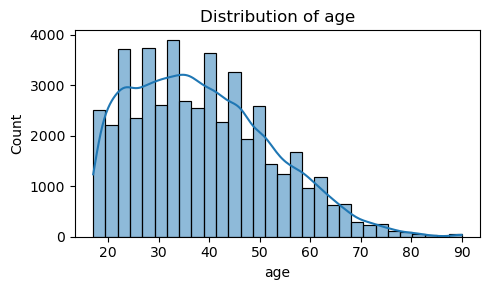

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


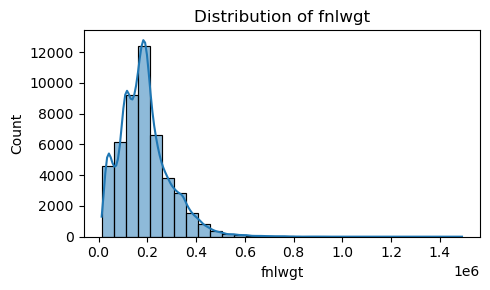

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


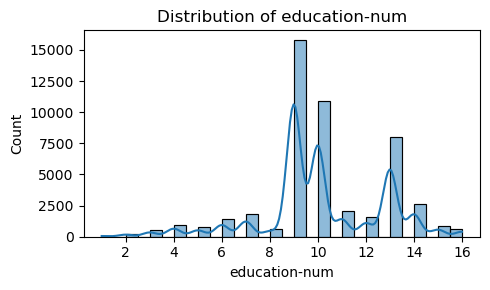

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


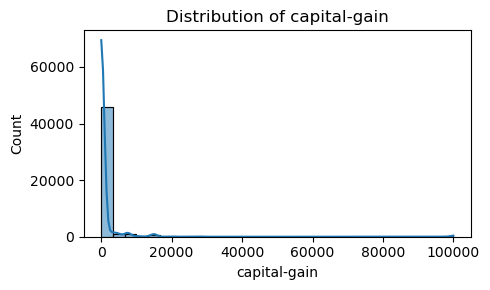

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


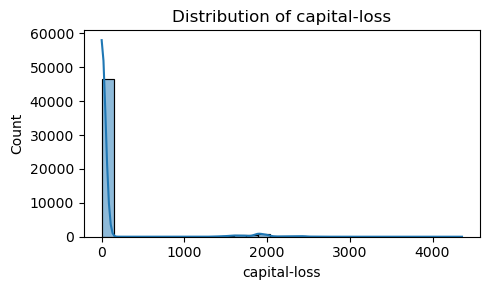

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


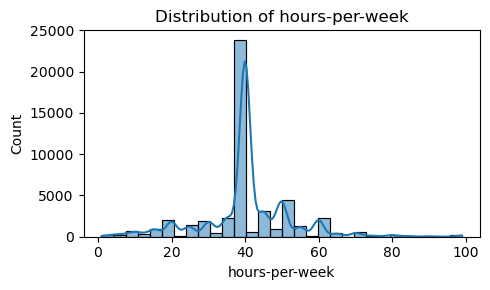

In [47]:
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


Value counts for workclass:
 workclass
Private             36705
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

Proportions for workclass:
 workclass
Private             0.751505
Self-emp-not-inc    0.079071
Local-gov           0.064207
State-gov           0.040559
Self-emp-inc        0.034704
Federal-gov         0.029319
Without-pay         0.000430
Never-worked        0.000205
Name: proportion, dtype: float64


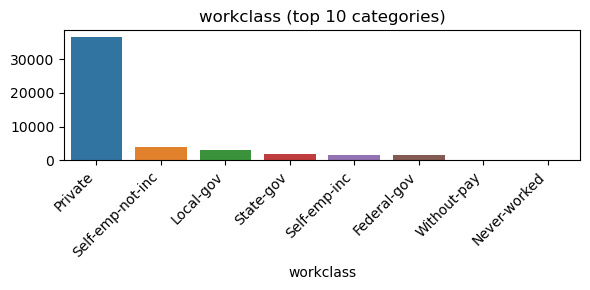


Value counts for education:
 education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

Proportions for education:
 education
HS-grad         0.323164
Some-college    0.222718
Bachelors       0.164305
Masters         0.054400
Assoc-voc       0.042197
11th            0.037099
Assoc-acdm      0.032779
10th            0.028439
7th-8th         0.019553
Prof-school     0.017075
9th             0.015478
12th            0.013452
Doctorate       0.012162
5th-6th         0.010421
1st-4th         0.005057
Preschool       0.001699
Name: proportion, dtype: float64


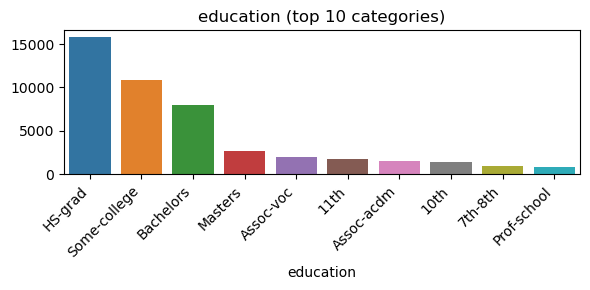


Value counts for marital-status:
 marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

Proportions for marital-status:
 marital-status
Married-civ-spouse       0.458192
Never-married            0.329982
Divorced                 0.135805
Separated                0.031325
Widowed                  0.031080
Married-spouse-absent    0.012858
Married-AF-spouse        0.000758
Name: proportion, dtype: float64


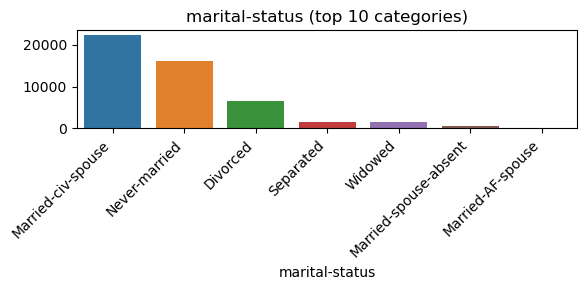


Value counts for occupation:
 occupation
Prof-specialty       8981
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

Proportions for occupation:
 occupation
Prof-specialty       0.183879
Craft-repair         0.125138
Exec-managerial      0.124606
Adm-clerical         0.114881
Sales                0.112690
Other-service        0.100794
Machine-op-inspct    0.061873
Transport-moving     0.048217
Handlers-cleaners    0.042423
Farming-fishing      0.030507
Tech-support         0.029606
Protective-serv      0.020126
Priv-house-serv      0.004955
Armed-Forces         0.000307
Name: proportion, dtype: float64


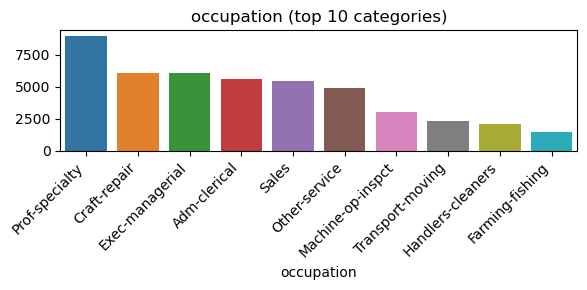


Value counts for relationship:
 relationship
Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: count, dtype: int64

Proportions for relationship:
 relationship
Husband           0.403669
Not-in-family     0.257627
Own-child         0.155215
Unmarried         0.104930
Wife              0.047725
Other-relative    0.030834
Name: proportion, dtype: float64


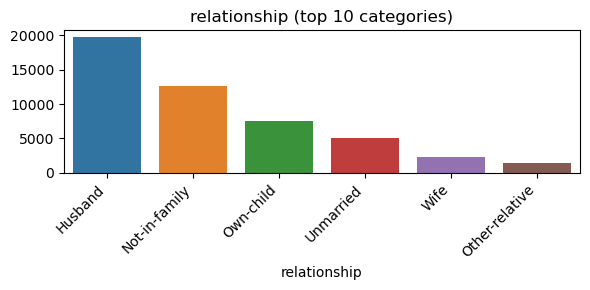


Value counts for race:
 race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64

Proportions for race:
 race
White                 0.855043
Black                 0.095922
Asian-Pac-Islander    0.031100
Amer-Indian-Eskimo    0.009623
Other                 0.008313
Name: proportion, dtype: float64


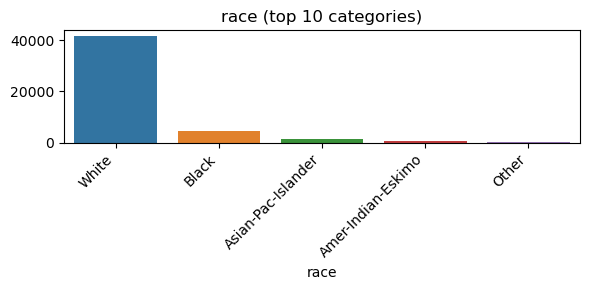


Value counts for sex:
 sex
Male      32650
Female    16192
Name: count, dtype: int64

Proportions for sex:
 sex
Male      0.668482
Female    0.331518
Name: proportion, dtype: float64


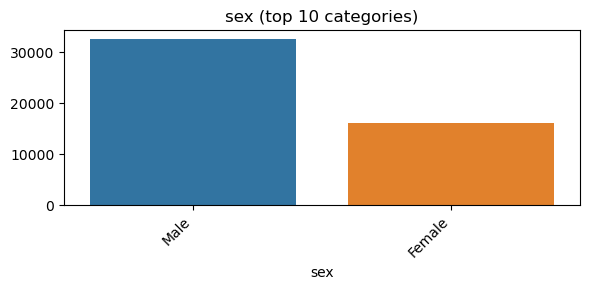


Value counts for native-country:
 native-country
United-States                 44689
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru          

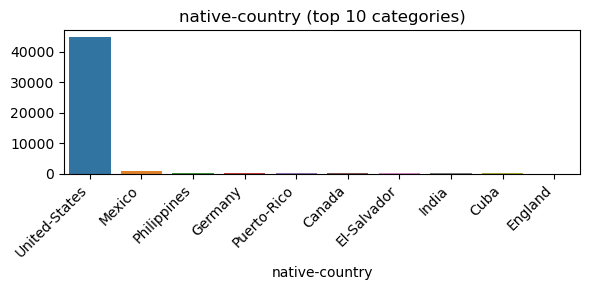

In [48]:
for col in categorical_cols:
    print(f"\nValue counts for {col}:\n", X[col].value_counts())
    print(f"\nProportions for {col}:\n", X[col].value_counts(normalize=True))

    plt.figure(figsize=(6, 3))
    value_counts = X[col].value_counts().head(10)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"{col} (top 10 categories)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Target rate by workclass (row-normalized):
 income                   0         1
workclass                           
Federal-gov       0.608240  0.391760
Local-gov         0.704401  0.295599
Never-worked      1.000000  0.000000
Private           0.791527  0.208473
Self-emp-inc      0.446608  0.553392
Self-emp-not-inc  0.721129  0.278871
State-gov         0.732458  0.267542
Without-pay       0.904762  0.095238


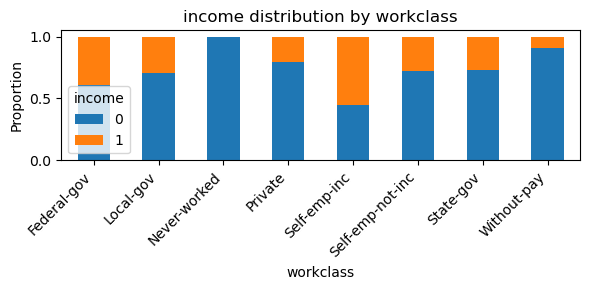


Target rate by education (row-normalized):
 income               0         1
education                       
10th          0.937365  0.062635
11th          0.949227  0.050773
12th          0.926941  0.073059
1st-4th       0.967611  0.032389
5th-6th       0.946955  0.053045
7th-8th       0.935079  0.064921
9th           0.945767  0.054233
Assoc-acdm    0.742036  0.257964
Assoc-voc     0.746725  0.253275
Bachelors     0.587165  0.412835
Doctorate     0.274411  0.725589
HS-grad       0.841422  0.158578
Masters       0.450884  0.549116
Preschool     0.987952  0.012048
Prof-school   0.260192  0.739808
Some-college  0.810351  0.189649


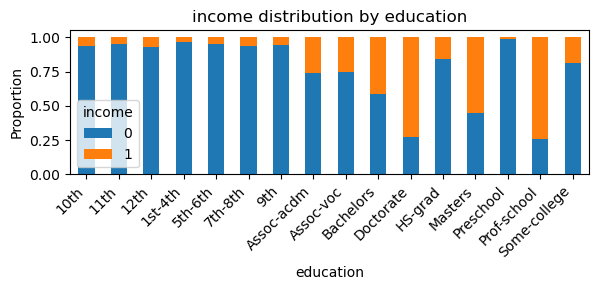


Target rate by marital-status (row-normalized):
 income                        0         1
marital-status                           
Divorced               0.898839  0.101161
Married-AF-spouse      0.621622  0.378378
Married-civ-spouse     0.553867  0.446133
Married-spouse-absent  0.907643  0.092357
Never-married          0.954520  0.045480
Separated              0.935294  0.064706
Widowed                0.915679  0.084321


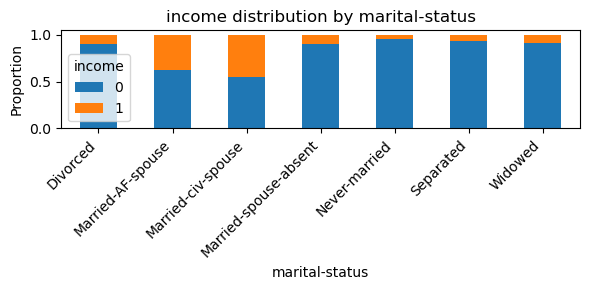


Target rate by occupation (row-normalized):
 income                    0         1
occupation                           
Adm-clerical       0.863126  0.136874
Armed-Forces       0.666667  0.333333
Craft-repair       0.773724  0.226276
Exec-managerial    0.522182  0.477818
Farming-fishing    0.883893  0.116107
Handlers-cleaners  0.933398  0.066602
Machine-op-inspct  0.876903  0.123097
Other-service      0.958562  0.041438
Priv-house-serv    0.987603  0.012397
Prof-specialty     0.660506  0.339494
Protective-serv    0.686673  0.313327
Sales              0.732013  0.267987
Tech-support       0.709544  0.290456
Transport-moving   0.795754  0.204246


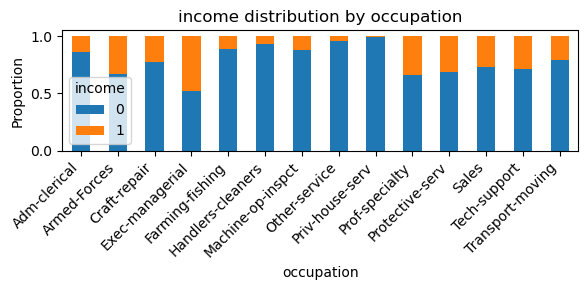


Target rate by relationship (row-normalized):
 income                 0         1
relationship                      
Husband         0.551329  0.448671
Not-in-family   0.898593  0.101407
Other-relative  0.965471  0.034529
Own-child       0.985358  0.014642
Unmarried       0.939707  0.060293
Wife            0.531103  0.468897


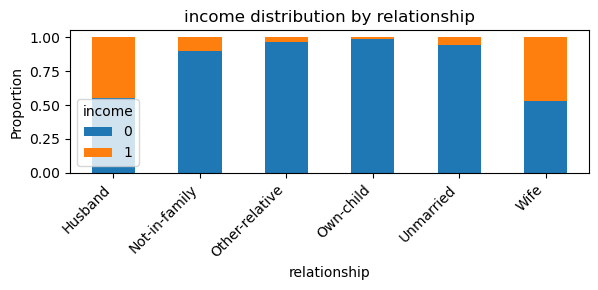


Target rate by race (row-normalized):
 income                     0         1
race                                  
Amer-Indian-Eskimo  0.882979  0.117021
Asian-Pac-Islander  0.730744  0.269256
Black               0.879189  0.120811
Other               0.876847  0.123153
White               0.746013  0.253987


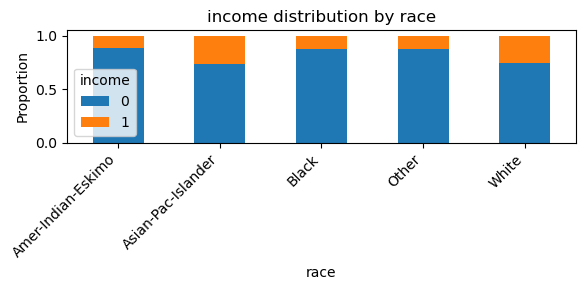


Target rate by sex (row-normalized):
 income         0         1
sex                       
Female  0.890749  0.109251
Male    0.696233  0.303767


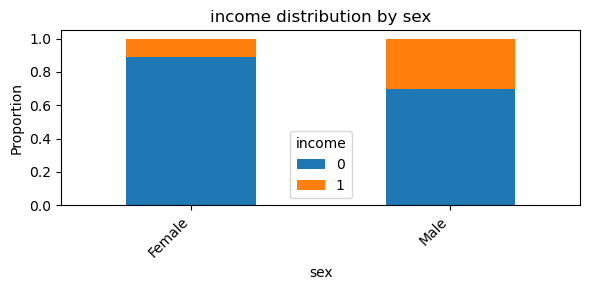

In [50]:
for col in categorical_cols:
    if col == "native-country":
        continue
    ct = pd.crosstab(X[col], y, normalize="index")
    print(f"\nTarget rate by {col} (row-normalized):\n", ct)

    plt.figure(figsize=(6, 3))
    ct.plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title(f"{y_name} distribution by {col}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title=y_name)
    plt.tight_layout()
    plt.show()

<Figure size 1200x400 with 0 Axes>

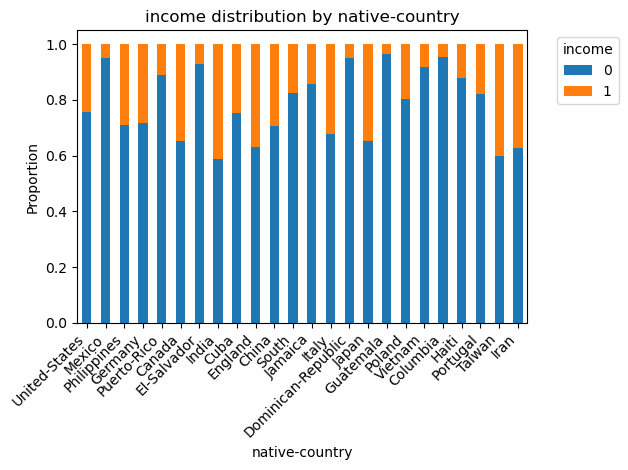

In [51]:
col = "native-country"

ct = pd.crosstab(X[col], y, normalize="index")

# Option 1: filter by minimum count
counts = X[col].value_counts()
valid_countries = counts[counts >= 50].index  # adjust threshold
ct = ct.loc[valid_countries]

plt.figure(figsize=(12, 4))  # wider figure
ax = ct.plot(kind="bar", stacked=True)
plt.title(f"{y_name} distribution by {col}")
plt.ylabel("Proportion")
plt.xlabel(col)
plt.xticks(rotation=45, ha="right")
plt.legend(title=y_name, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

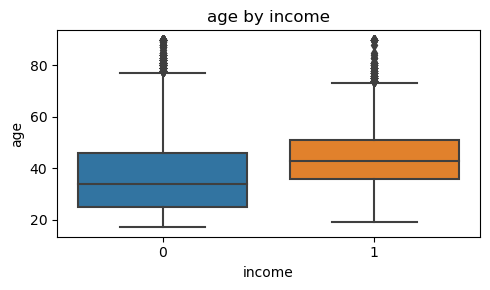

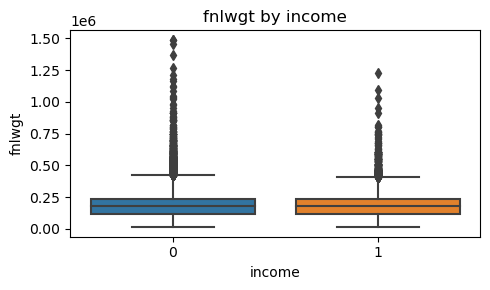

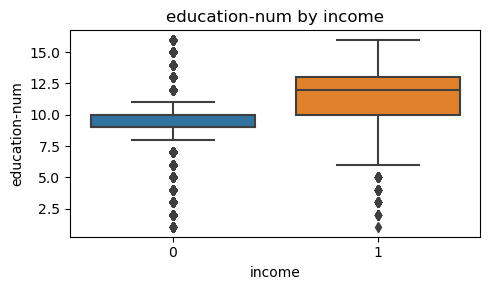

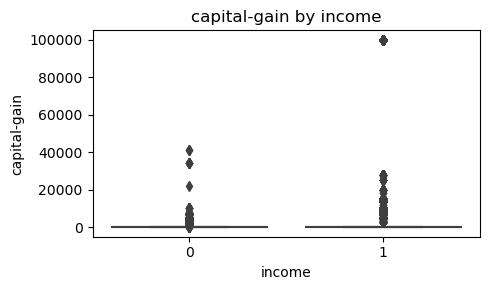

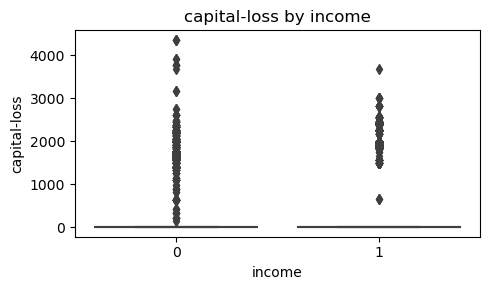

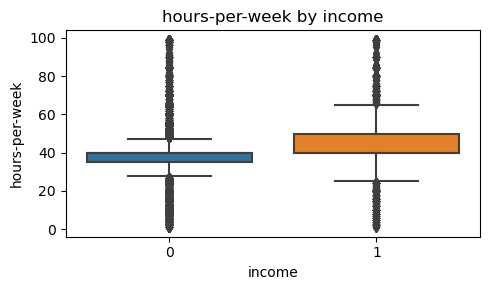

In [52]:
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=y, y=X[col])
    plt.title(f"{col} by {y_name}")
    plt.tight_layout()
    plt.show()

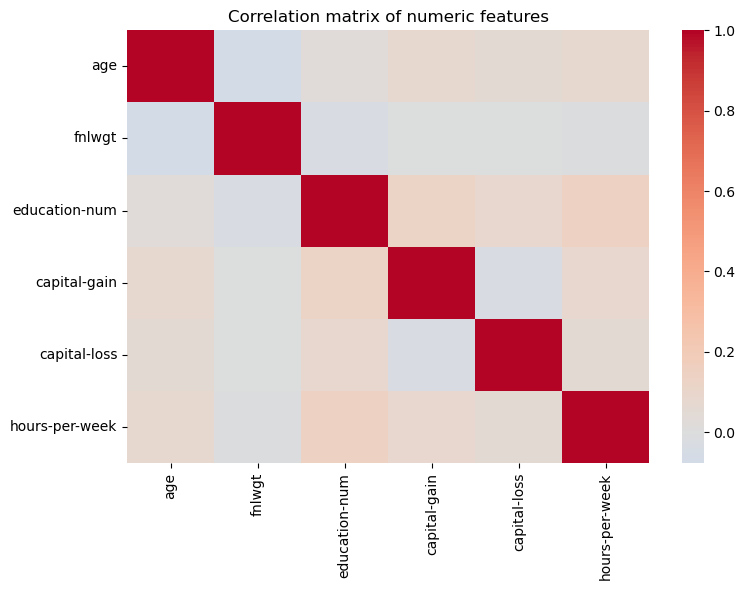

In [53]:
plt.figure(figsize=(8, 6))
corr = X[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation matrix of numeric features")
plt.tight_layout()
plt.show()

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

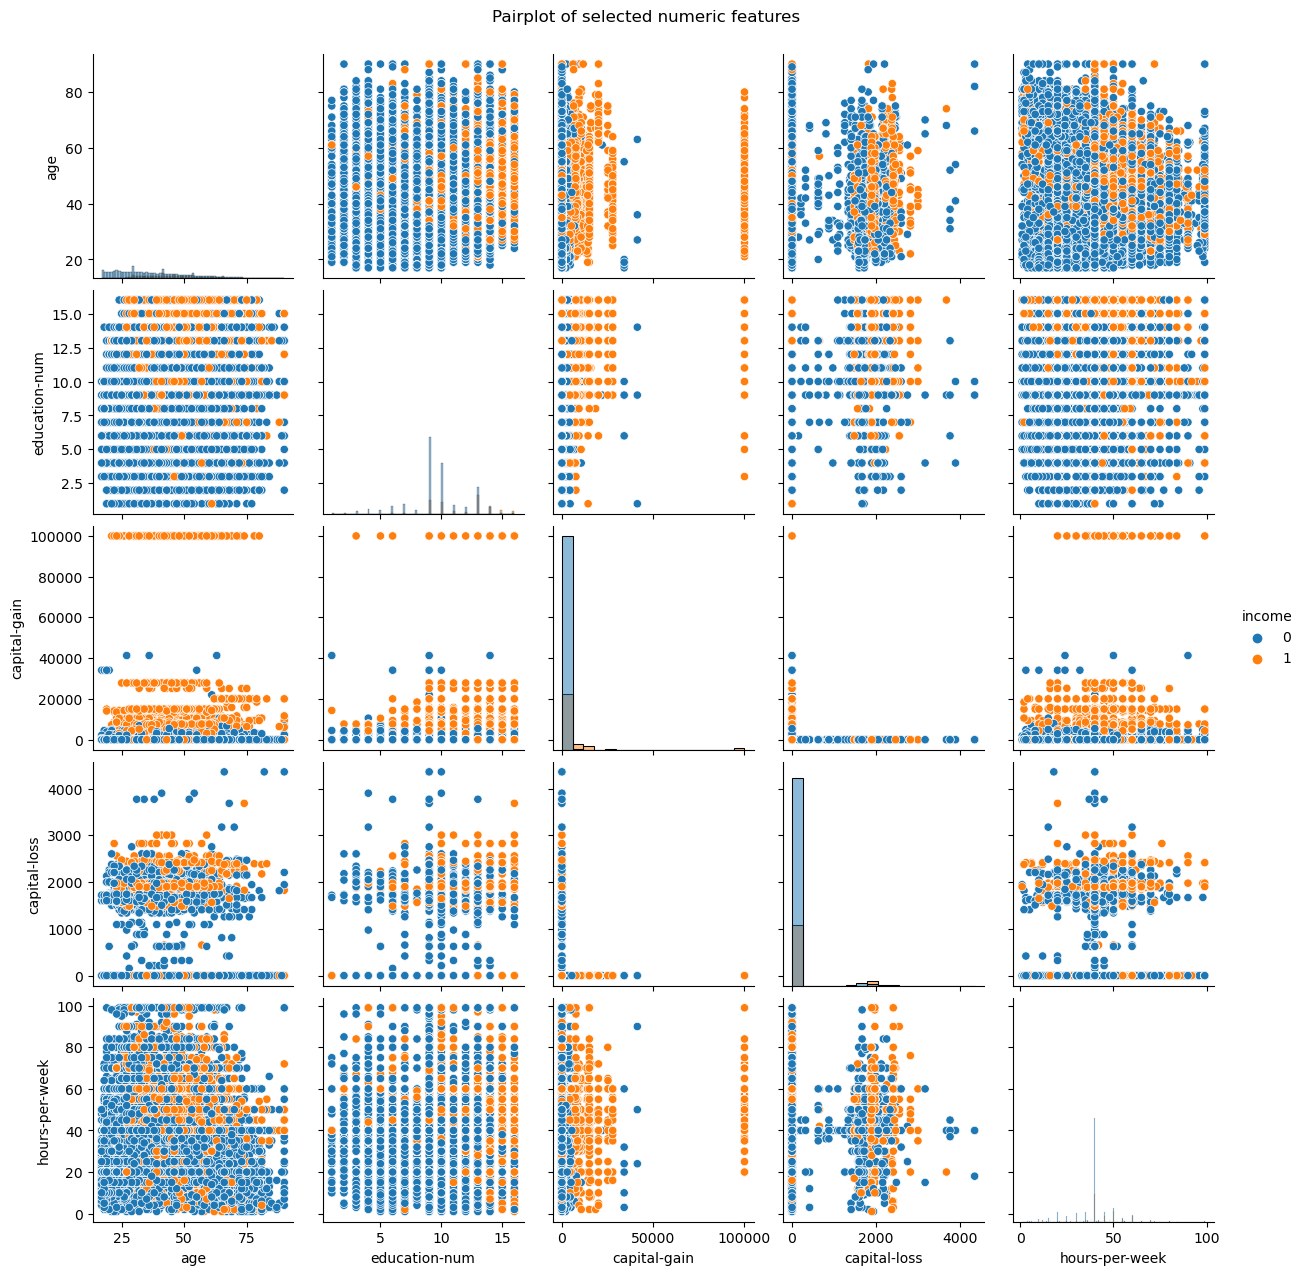

In [54]:
pairplot_cols = [c for c in numeric_cols if c.lower() in 
                 ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]]
pairplot_cols = [c for c in pairplot_cols if c in X.columns]

if len(pairplot_cols) >= 2:
    df_pair = pd.concat([X[pairplot_cols], y.rename(y_name)], axis=1)
    sns.pairplot(df_pair, hue=y_name, diag_kind="hist")
    plt.suptitle("Pairplot of selected numeric features", y=1.02)
    plt.show()

# Data Preprocessing

In [55]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

## Fairness Metrics Function

In [56]:
def fairness_metrics(X_test, y_true, y_pred, feature):
    """
    Calculate fairness metrics for a specific sensitive feature.
    
    - Returns Positive Rates, TPR, FPR, and accuracy for each group.
    - Returns fairness metrics: disparate impact, equal opportunity difference, and equalized odds difference.
    
    Privileged groups are Male (for sex) and White (for race).
    Protected groups are Female (for sex) and Non-White (for race).
    """
    df_eval = X_test.copy()
    df_eval['y_true'] = y_true.values if hasattr(y_true, 'values') else y_true
    df_eval['y_pred'] = y_pred

    metrics = []
    
    if feature == 'sex':
        groups = ['Male', 'Female']
    elif feature == 'race':
        # combine all non-White as 'Non-White'
        df_eval['race_grouped'] = df_eval['race'].apply(lambda x: 'White' if x == 'White' else 'Non-White')
        groups = ['White', 'Non-White']
        feature = 'race_grouped'
    else:
        groups = df_eval[feature].unique()

    for g in groups:
        mask = df_eval[feature] == g
        y_t = df_eval.loc[mask, 'y_true']
        y_p = df_eval.loc[mask, 'y_pred']

        # Positive prediction rate (Demographic Parity)
        pos_rate = np.mean(y_p)

        # True Positive Rate (Equal Opportunity)
        tp = np.sum((y_p == 1) & (y_t == 1))
        fn = np.sum((y_p == 0) & (y_t == 1))
        tpr = tp / (tp + fn + 1e-10)

        # False Positive Rate (Equalized Odds)
        fp = np.sum((y_p == 1) & (y_t == 0))
        tn = np.sum((y_p == 0) & (y_t == 0))
        fpr = fp / (fp + tn + 1e-10)

        # Accuracy
        acc = np.mean(y_p == y_t)

        metrics.append({
            'group': g,
            'positive_rate': pos_rate,
            'TPR': tpr,
            'FPR': fpr,
            'accuracy': acc
        })

    df_metrics = pd.DataFrame(metrics)
    print(f"\n=== Fairness by {feature} ===")
    print(df_metrics.to_string(index=False))

    # Privileged / Protected groups
    privileged = 'Male' if feature == 'sex' else 'White'
    protected = 'Female' if feature == 'sex' else 'Non-White'

    # Extract values
    p_priv = df_metrics.loc[df_metrics['group'] == privileged, 'positive_rate'].values[0]
    p_prot = df_metrics.loc[df_metrics['group'] == protected, 'positive_rate'].values[0]

    tpr_priv = df_metrics.loc[df_metrics['group'] == privileged, 'TPR'].values[0]
    tpr_prot = df_metrics.loc[df_metrics['group'] == protected, 'TPR'].values[0]

    fpr_priv = df_metrics.loc[df_metrics['group'] == privileged, 'FPR'].values[0]
    fpr_prot = df_metrics.loc[df_metrics['group'] == protected, 'FPR'].values[0]

    # Disparate Impact
    disparate_impact = (p_prot + 1e-10) / (p_priv + 1e-10)

    # Equal Opportunity Difference (TPR difference)
    equal_opp_diff = tpr_prot - tpr_priv

    # Equalized Odds Differences
    equalized_odds_tpr_diff = tpr_prot - tpr_priv
    equalized_odds_fpr_diff = fpr_prot - fpr_priv

    print("\n=== GROUP FAIRNESS DISPARITIES ===")
    print(f"Privileged group: {privileged}, Protected group: {protected}")
    print(f"Disparate Impact: {disparate_impact:.4f}")
    print(f"Equal Opportunity Difference (TPR diff): {equal_opp_diff:.4f}")
    print(f"Equalized Odds Differences: TPR diff={equalized_odds_tpr_diff:.4f}, "
          f"FPR diff={equalized_odds_fpr_diff:.4f}")

    disparities = {
        'disparate_impact': disparate_impact,
        'equal_opportunity_difference': equal_opp_diff,
        'equalized_odds_tpr_diff': equalized_odds_tpr_diff,
        'equalized_odds_fpr_diff': equalized_odds_fpr_diff
    }

    return df_metrics, disparities

def evaluate_model_full(name, model, X_model_input, y_true, X_sensitive, 
                        fairness_metrics_func=fairness_metrics):
    """
    Evaluate a model with standard metrics and fairness metrics.
    
    Works with both sklearn models and PyTorch models.
    """
    # Detect if PyTorch model
    is_torch_model = isinstance(model, torch.nn.Module)

    if is_torch_model:
        # Ensure tensor input
        if not torch.is_tensor(X_model_input):
            X_model_input = torch.tensor(X_model_input, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            outputs = model(X_model_input)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
    else:
        # sklearn model
        y_pred = model.predict(X_model_input)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_model_input)[:, 1]
        else:
            probs = y_pred

    # Standard metrics
    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')

    print(f"\n{'='*70}")
    print(f"EVALUATION: {name}")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"AUC-ROC Score: {auc:.4f}")

    # Fairness metrics
    sex_metrics = race_metrics = None
    if fairness_metrics_func and X_sensitive is not None:
        if 'sex' in X_sensitive.columns:
            sex_metrics, sex_disparities = fairness_metrics_func(X_sensitive, y_true, y_pred, 'sex')
        if 'race' in X_sensitive.columns:
            race_metrics, race_disparities = fairness_metrics_func(X_sensitive, y_true, y_pred, 'race')

    return {
        "name": name,
        "accuracy": acc,
        "auc": auc,
        "y_pred": y_pred,
        "sex_metrics": sex_metrics,
        "race_metrics": race_metrics,
        "sex_disparities": sex_disparities,
        "race_disparities": race_disparities 
    }

## Pytorch Model Definition

In [57]:
class LogisticRegressionModel(nn.Module):
    """Simple logistic regression model for binary classification."""
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.linear(x)

# BASELINE MODEL (NO DIFFERENTIAL PRIVACY)

In [58]:
def train_baseline_model(X_train, y_train, X_test, y_test, 
                         max_iter=1000, random_state=RANDOM_SEED):
    """
    Train a baseline logistic regression model without any privacy protection.
    
    Args:
        X_train, y_train: Training data (pandas DataFrames/Series)
        X_test, y_test: Test data
        max_iter: Maximum iterations for sklearn LogisticRegression
        random_state: Random seed
        
    Returns:
        model: Trained sklearn pipeline
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING BASELINE MODEL (No Differential Privacy)")
    print(f"{'='*70}")
    
    # Create preprocessing + model pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=max_iter, random_state=random_state))
    ])
    
    # Train
    clf.fit(X_train, y_train)
    print("✓ Training completed")
    
    # Evaluate
    results = evaluate_model_full(
        name="Baseline (No DP)",
        model=clf,
        X_model_input=X_test,
        y_true=y_test,
        X_sensitive=X_test
    )
    
    return clf, results


# STANDARD DP-SGD MODEL (OPACUS)

In [59]:
def train_standard_dpsgd(X_train_tensor, y_train_tensor, X_test_tensor, y_test,
                         X_test_df, noise_multiplier=1.0, max_grad_norm=1.0,
                         lr=0.01, epochs=10, batch_size=64, delta=1e-5):
    """
    Train a logistic regression model with standard DP-SGD using Opacus.
    All gradients are protected with differential privacy.
    
    Args:
        X_train_tensor: Preprocessed training features (torch tensor)
        y_train_tensor: Training labels (torch tensor)
        X_test_tensor: Preprocessed test features (torch tensor)
        y_test: Test labels (pandas Series or numpy array)
        X_test_df: Original test dataframe for fairness evaluation
        noise_multiplier: Controls noise magnitude (higher = more privacy)
        max_grad_norm: Gradient clipping threshold (lower = more privacy)
        lr: Learning rate
        epochs: Number of training epochs
        batch_size: Batch size
        delta: Privacy parameter (typically 1e-5)
        
    Returns:
        model: Trained PyTorch model
        epsilon: Privacy budget (ε)
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING STANDARD DP-SGD MODEL")
    print(f"{'='*70}")
    print(f"Hyperparameters:")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Noise multiplier: {noise_multiplier}")
    print(f"  - Max grad norm: {max_grad_norm}")
    print(f"  - Delta (δ): {delta}")
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = LogisticRegressionModel(X_train_tensor.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Attach Privacy Engine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("Training completed")
    
    # Calculate privacy budget
    epsilon = privacy_engine.get_epsilon(delta=delta)
    print(f"\n{'='*70}")
    print("PRIVACY BUDGET")
    print(f"{'='*70}")
    print(f"Epsilon (ε): {epsilon:.4f}")
    print(f"Delta (δ): {delta}")
    print(f"\nInterpretation:")
    print(f"  - ALL features are protected with ε={epsilon:.4f} privacy")
    print(f"  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)")
    
    # Evaluate
    results = evaluate_model_full(
        name=f"Standard DP-SGD (ε={epsilon:.3f})",
        model=model,
        X_model_input=X_test_tensor,
        y_true=y_test,
        X_sensitive=X_test_df
    )
    
    results['epsilon'] = epsilon
    results['delta'] = delta
    
    return model, epsilon, results

# SELECTIVE DP-SGD MODEL (MANUAL IMPLEMENTATION)

In [60]:
def train_selective_dpsgd(X_train_tensor, y_train_tensor, X_test_tensor, y_test,
                          X_test_df, sensitive_indices, noise_multiplier=1.0,
                          max_grad_norm=1.0, lr=0.01, epochs=10, batch_size=64,
                          delta=1e-5):
    """
    Train a logistic regression model with Selective DP-SGD.
    Only gradients corresponding to sensitive features are protected with DP noise.
    
    Args:
        X_train_tensor: Preprocessed training features (torch tensor)
        y_train_tensor: Training labels (torch tensor)
        X_test_tensor: Preprocessed test features (torch tensor)
        y_test: Test labels
        X_test_df: Original test dataframe for fairness evaluation
        sensitive_indices: List of feature indices to protect (e.g., sex, race)
        noise_multiplier: Controls noise magnitude (higher = more privacy)
        max_grad_norm: Gradient clipping threshold (lower = more privacy)
        lr: Learning rate
        epochs: Number of training epochs
        batch_size: Batch size
        delta: Privacy parameter
        
    Returns:
        model: Trained PyTorch model
        epsilon: Privacy budget for sensitive features
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING SELECTIVE DP-SGD MODEL")
    print(f"{'='*70}")
    print(f"Hyperparameters:")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Noise multiplier: {noise_multiplier}")
    print(f"  - Max grad norm: {max_grad_norm}")
    print(f"  - Delta (δ): {delta}")
    print(f"  - Sensitive feature indices: {sensitive_indices}")
    
    # Initialize model
    model = LogisticRegressionModel(X_train_tensor.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop with selective DP
    n_samples = len(X_train_tensor)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    model.train()
    for epoch in range(epochs):
        # Shuffle data
        indices = torch.randperm(n_samples)
        X_shuffled = X_train_tensor[indices]
        y_shuffled = y_train_tensor[indices]
        
        epoch_loss = 0
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, n_samples)
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Apply selective DP to gradients
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if "linear.weight" in name and param.grad is not None:
                        grad = param.grad
                        
                        # Create mask for sensitive features
                        mask = torch.zeros_like(grad)
                        mask[:, sensitive_indices] = 1.0
                        
                        # Clip sensitive feature gradients
                        sensitive_grad = grad * mask
                        grad_norm = sensitive_grad.norm(2)
                        if grad_norm > max_grad_norm:
                            # Normalize only sensitive gradients
                            clipped_sensitive = sensitive_grad * (max_grad_norm / grad_norm)
                            # Combine: non-sensitive (unchanged) + clipped sensitive
                            grad.data = grad * (1.0 - mask) + clipped_sensitive
                        
                        # Add Gaussian noise ONLY to sensitive features
                        noise = torch.normal(
                            mean=0.0,
                            std=noise_multiplier * max_grad_norm,
                            size=grad.shape,
                            device=grad.device
                        )
                        param.grad.add_(noise * mask)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("Training completed")
    
    # Calculate privacy budget for sensitive features
    steps = epochs * n_batches
    q = batch_size / n_samples  # Sampling rate
    
    # Use RDP accountant to compute APPROXIMATE epsilon
    orders = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
    rdp = privacy_analysis.compute_rdp(
        q=q,
        noise_multiplier=noise_multiplier,
        steps=steps,
        orders=orders
    )
    epsilon = privacy_analysis.get_privacy_spent(orders=orders, rdp=rdp, delta=delta)[0]
    
    print(f"\n{'='*70}")
    print("PRIVACY BUDGET (SELECTIVE)")
    print(f"{'='*70}")
    print(f"Epsilon (ε): {epsilon:.4f}")
    print(f"Delta (δ): {delta}")
    print(f"\nInterpretation:")
    print(f"  - Sensitive features (indices {sensitive_indices}) have ε={epsilon:.4f} privacy")
    print(f"  - Non-sensitive features have NO formal privacy guarantee")
    print(f"  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)")
    
    # Evaluate
    results = evaluate_model_full(
        name=f"Selective DP-SGD (ε={epsilon:.3f})",
        model=model,
        X_model_input=X_test_tensor,
        y_true=y_test,
        X_sensitive=X_test_df
    )
    
    results['epsilon'] = epsilon
    results['delta'] = delta
    
    return model, epsilon, results

In [66]:
def train_selective_dpsgd(X_train_tensor, y_train_tensor, X_test_tensor, y_test,
                          X_test_df, sensitive_indices, noise_multiplier=1.0,
                          max_grad_norm=1.0, lr=0.01, epochs=10, batch_size=64,
                          delta=1e-5):
    """
    Train a logistic regression model with Selective DP-SGD.
    Only gradients corresponding to sensitive features are protected with DP noise.
    Uses proper per-sample gradient computation for valid DP guarantees.
    """
    print(f"\n{'='*70}")
    print("TRAINING SELECTIVE DP-SGD MODEL")
    print(f"{'='*70}")
    print(f"Hyperparameters:")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Noise multiplier: {noise_multiplier}")
    print(f"  - Max grad norm: {max_grad_norm}")
    print(f"  - Delta (δ): {delta}")
    print(f"  - Sensitive feature indices: {sensitive_indices}")
    
    # Initialize model
    model = LogisticRegressionModel(X_train_tensor.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction='none')  # Important: per-sample loss
    
    # Training loop with selective DP
    n_samples = len(X_train_tensor)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    model.train()
    for epoch in range(epochs):
        # Shuffle data
        indices = torch.randperm(n_samples)
        X_shuffled = X_train_tensor[indices]
        y_shuffled = y_train_tensor[indices]
        
        epoch_loss = 0
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, n_samples)
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            current_batch_size = len(X_batch)
            
            optimizer.zero_grad()
            
            # Compute per-sample gradients
            per_sample_grads = []
            
            for i in range(current_batch_size):
                # Forward pass for single sample
                output = model(X_batch[i:i+1])
                loss = criterion(output, y_batch[i:i+1])
                
                # Backward pass for single sample
                model.zero_grad()
                loss.backward()
                
                # Extract and process gradients for this sample
                for name, param in model.named_parameters():
                    if "linear.weight" in name and param.grad is not None:
                        sample_grad = param.grad.clone()
                        
                        # Create mask for sensitive features
                        mask = torch.zeros_like(sample_grad)
                        mask[:, sensitive_indices] = 1.0
                        
                        # Separate sensitive and non-sensitive components
                        sensitive_grad = sample_grad * mask
                        non_sensitive_grad = sample_grad * (1.0 - mask)
                        
                        # Clip ONLY sensitive gradients
                        sensitive_norm = sensitive_grad.norm(2)
                        if sensitive_norm > max_grad_norm:
                            sensitive_grad = sensitive_grad * (max_grad_norm / sensitive_norm)
                        
                        # Recombine: clipped sensitive + original non-sensitive
                        clipped_grad = non_sensitive_grad + sensitive_grad
                        
                        # Store per-sample gradient
                        if i == 0:
                            per_sample_grads.append(clipped_grad.unsqueeze(0))
                        else:
                            per_sample_grads[-1] = torch.cat([per_sample_grads[-1], 
                                                              clipped_grad.unsqueeze(0)], dim=0)
            
            # Average clipped per-sample gradients and add noise
            with torch.no_grad():
                for idx, (name, param) in enumerate(model.named_parameters()):
                    if "linear.weight" in name:
                        # Average the clipped gradients
                        avg_grad = per_sample_grads[0].mean(dim=0)
                        
                        # Create mask for sensitive features
                        mask = torch.zeros_like(avg_grad)
                        mask[:, sensitive_indices] = 1.0
                        
                        # Add Gaussian noise ONLY to sensitive features
                        noise = torch.normal(
                            mean=0.0,
                            std=noise_multiplier * max_grad_norm,
                            size=avg_grad.shape,
                            device=avg_grad.device
                        )
                        
                        # Set gradient: averaged clipped gradient + selective noise
                        param.grad = avg_grad + (noise * mask)
            
            optimizer.step()
            epoch_loss += loss.sum().item()
        
        avg_loss = epoch_loss / n_samples
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("Training completed")
    
    # Calculate privacy budget for sensitive features
    steps = epochs * n_batches
    q = batch_size / n_samples  # Sampling rate
    
    # Use RDP accountant
    orders = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
    rdp = privacy_analysis.compute_rdp(
        q=q,
        noise_multiplier=noise_multiplier,
        steps=steps,
        orders=orders
    )
    epsilon = privacy_analysis.get_privacy_spent(orders=orders, rdp=rdp, delta=delta)[0]
    
    print(f"\n{'='*70}")
    print("PRIVACY BUDGET (SELECTIVE)")
    print(f"{'='*70}")
    print(f"Epsilon (ε): {epsilon:.4f}")
    print(f"Delta (δ): {delta}")
    print(f"\nInterpretation:")
    print(f"  - Sensitive features (indices {sensitive_indices}) have ε={epsilon:.4f} privacy")
    print(f"  - Non-sensitive features have NO formal privacy guarantee")
    print(f"  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)")
    
    # Evaluate
    results = evaluate_model_full(
        name=f"Selective DP-SGD (ε={epsilon:.3f})",
        model=model,
        X_model_input=X_test_tensor,
        y_true=y_test,
        X_sensitive=X_test_df
    )
    
    results['epsilon'] = epsilon
    results['delta'] = delta
    
    return model, epsilon, results

# MAIN EXECUTION

In [61]:
if __name__ == "__main__":
    print("\n" + "="*70)
    print("PREPROCESSING DATA FOR PYTORCH MODELS")
    print("="*70)
    
    # Preprocess features
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convert to torch tensors
    def to_tensor(x):
        if hasattr(x, "toarray"):
            return torch.tensor(x.toarray(), dtype=torch.float32)
        return torch.tensor(x, dtype=torch.float32)
    
    X_train_tensor = to_tensor(X_train_processed)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = to_tensor(X_test_processed)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    print(f"Train tensor shape: {X_train_tensor.shape}")
    print(f"Test tensor shape: {X_test_tensor.shape}")
    
    # Identify sensitive feature indices
    print("\n" + "="*70)
    print("IDENTIFYING SENSITIVE FEATURES")
    print("="*70)
    
    encoded_feature_names = preprocessor.get_feature_names_out()
    sensitive_indices = []
    for idx, name in enumerate(encoded_feature_names):
        if name.startswith('cat__sex_') or name.startswith('cat__race_'):
            sensitive_indices.append(idx)
    
    print(f"Total features after encoding: {len(encoded_feature_names)}")
    print(f"Sensitive feature indices: {sensitive_indices}")
    print(f"Sensitive feature names:")
    for idx in sensitive_indices:
        print(f"  [{idx}] {encoded_feature_names[idx]}")


PREPROCESSING DATA FOR PYTORCH MODELS
Train tensor shape: torch.Size([39073, 105])
Test tensor shape: torch.Size([9769, 105])

IDENTIFYING SENSITIVE FEATURES
Total features after encoding: 105
Sensitive feature indices: [57, 58, 59, 60, 61, 62, 63]
Sensitive feature names:
  [57] cat__race_Amer-Indian-Eskimo
  [58] cat__race_Asian-Pac-Islander
  [59] cat__race_Black
  [60] cat__race_Other
  [61] cat__race_White
  [62] cat__sex_Female
  [63] cat__sex_Male


In [62]:
#1. Baseline Model
baseline_model, baseline_results = train_baseline_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    max_iter=1000
)


TRAINING BASELINE MODEL (No Differential Privacy)
✓ Training completed

EVALUATION: Baseline (No DP)
Overall Accuracy: 0.8508
AUC-ROC Score: 0.9042

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.254321 0.612887 0.097583  0.814352
Female       0.076011 0.493188 0.023614  0.922469

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2989
Equal Opportunity Difference (TPR diff): -0.1197
Equalized Odds Differences: TPR diff=-0.1197, FPR diff=-0.0740

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.208313 0.604059 0.073688  0.844514
Non-White       0.111893 0.497717 0.041597  0.887403

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: White, Protected group: Non-White
Disparate Impact: 0.5371
Equal Opportunity Difference (TPR diff): -0.1063
Equalized Odds Differences: TPR diff=-0.1063, FPR diff=-0.0321


In [68]:
# 2. Standard DP-SGD Model
dpsgd_model, dpsgd_epsilon, dpsgd_results = train_standard_dpsgd(
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor,
        y_test=y_test,
        X_test_df=X_test,
        noise_multiplier=1.0,
        max_grad_norm=1.0,
        lr=0.01,
        epochs=10,
        batch_size=64,
        delta=1e-5
    )


TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 1.0
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5142
Epoch 2/10 - Loss: 0.4762
Epoch 3/10 - Loss: 0.4362
Epoch 4/10 - Loss: 0.4057
Epoch 5/10 - Loss: 0.3955
Epoch 6/10 - Loss: 0.3800
Epoch 7/10 - Loss: 0.3884
Epoch 8/10 - Loss: 0.3893
Epoch 9/10 - Loss: 0.3879
Epoch 10/10 - Loss: 0.3840
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8327
AUC-ROC Score: 0.8852

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.224228 0.531710 0.089820  0.795062
Female       0.034357 0.237057 0.008898  0.906963

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1532
Equal Opportunity Difference (TPR diff): -0.2947
Equalized Odds Differences: TPR diff=-0.2947, FPR diff=-0.0809

=== Fairness by race_grouped ===
    group  positive_rate

In [67]:
# 3. Selective DP-SGD Model
selective_model, selective_epsilon, selective_results = train_selective_dpsgd(
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor,
        y_test=y_test,
        X_test_df=X_test,
        sensitive_indices=sensitive_indices,
        noise_multiplier=1.0,
        max_grad_norm=1.0,
        lr=0.01,
        epochs=10,
        batch_size=64,
        delta=1e-5
    )


TRAINING SELECTIVE DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 1.0
  - Delta (δ): 1e-05
  - Sensitive feature indices: [57, 58, 59, 60, 61, 62, 63]
Epoch 1/10 - Loss: 0.0065
Epoch 2/10 - Loss: 0.0059
Epoch 3/10 - Loss: 0.0056
Epoch 4/10 - Loss: 0.0058
Epoch 5/10 - Loss: 0.0056
Epoch 6/10 - Loss: 0.0061
Epoch 7/10 - Loss: 0.0051
Epoch 8/10 - Loss: 0.0049
Epoch 9/10 - Loss: 0.0054
Epoch 10/10 - Loss: 0.0053
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8448
AUC-ROC Score: 0.8988

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.262346 0.616946 0.1073

# Plots 

## Accuracy

In [69]:
# Helper function

def run_parameter_sweep(X_train_tensor, y_train_tensor, X_test_tensor, y_test, 
                       X_test_df, sensitive_indices, param_type='clipping',
                       param_values=None, fixed_noise=1.0, fixed_clipping=1.0,
                       lr=0.01, epochs=10, batch_size=64, delta=1e-5):
    """
    Run parameter sweep experiments for either clipping norm or noise multiplier.
    Returns:
        results_dict: Dictionary containing all results
    """
    if param_values is None:
        if param_type == 'clipping':
            param_values = [0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
        else:  # noise
            param_values = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
    
    results_dict = {}
    
    print(f"\n{'='*70}")
    print(f"RUNNING {param_type.upper()} PARAMETER SWEEP")
    print(f"{'='*70}")
    print(f"Testing {len(param_values)} values: {param_values}")
    print(f"This will train {len(param_values) * 2} models (Standard + Selective)")
    print()
    
    for param_val in tqdm(param_values, desc=f"Sweeping {param_type}"):
        results_dict[param_val] = {}
        
        # Set parameters based on sweep type
        if param_type == 'clipping':
            noise_mult = fixed_noise
            clip_norm = param_val
        else:  # noise
            noise_mult = param_val
            clip_norm = fixed_clipping
        
        print(f"\n--- Testing: {param_type}={param_val} ---")
        
        # Train Standard DP-SGD
        print("Training Standard DP-SGD...")
        _, _, standard_results = train_standard_dpsgd(
            X_train_tensor=X_train_tensor,
            y_train_tensor=y_train_tensor,
            X_test_tensor=X_test_tensor,
            y_test=y_test,
            X_test_df=X_test_df,
            noise_multiplier=noise_mult,
            max_grad_norm=clip_norm,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            delta=delta
        )
        results_dict[param_val]['standard_dpsgd'] = standard_results
        
        # Train Selective DP-SGD
        print("Training Selective DP-SGD...")
        _, _, selective_results = train_selective_dpsgd(
            X_train_tensor=X_train_tensor,
            y_train_tensor=y_train_tensor,
            X_test_tensor=X_test_tensor,
            y_test=y_test,
            X_test_df=X_test_df,
            sensitive_indices=sensitive_indices,
            noise_multiplier=noise_mult,
            max_grad_norm=clip_norm,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            delta=delta
        )
        results_dict[param_val]['selective_dpsgd'] = selective_results
    
    print(f"\n{'='*70}")
    print(f"PARAMETER SWEEP COMPLETE!")
    print(f"{'='*70}\n")
    
    return results_dict

## Clipping Norm Plots

In [70]:
def plot_clipping_accuracy(results_dict, save_path='clipping_accuracy.png'):
    """Plot overall accuracy vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    standard_acc = [results_dict[c]['standard_dpsgd']['accuracy'] for c in clipping_norms]
    selective_acc = [results_dict[c]['selective_dpsgd']['accuracy'] for c in clipping_norms]
    
    plt.figure(figsize=(10, 6))
    plt.plot(clipping_norms, standard_acc, marker='o', linewidth=2, 
             markersize=8, label='Standard DP-SGD', color='#2E86AB')
    plt.plot(clipping_norms, selective_acc, marker='s', linewidth=2, 
             markersize=8, label='Selective DP-SGD', color='#A23B72')
    
    plt.xlabel('Clipping Norm (C)', fontsize=12, fontweight='bold')
    plt.ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    plt.title('Effect of Gradient Clipping on Model Accuracy', 
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=11, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_clipping_accuracy_by_groups(results_dict, save_path='clipping_accuracy_groups.png'):
    """Plot accuracy by demographic groups vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # --- SEX GROUPS ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for model_type, ax, title in [('standard_dpsgd', ax1, 'Standard DP-SGD - Sex'),
                                    ('selective_dpsgd', ax2, 'Selective DP-SGD - Sex')]:
        male_acc = []
        female_acc = []
        
        for c in clipping_norms:
            # sex_metrics is a tuple: (DataFrame, disparities_dict)
            sex_data = results_dict[c][model_type]['sex_metrics']
            if isinstance(sex_data, tuple):
                sex_metrics, _ = sex_data
            else:
                sex_metrics = sex_data  # Fallback if it's just the DataFrame
            
            male_acc.append(sex_metrics[sex_metrics['group'] == 'Male']['accuracy'].values[0])
            female_acc.append(sex_metrics[sex_metrics['group'] == 'Female']['accuracy'].values[0])
        
        ax.plot(clipping_norms, male_acc, marker='o', linewidth=2, 
                markersize=7, label='Male', color='#1F77B4')
        ax.plot(clipping_norms, female_acc, marker='s', linewidth=2, 
                markersize=7, label='Female', color='#FF7F0E')
        
        ax.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # --- RACE GROUPS ---
    ax3 = fig.add_subplot(gs[1, :])
    
    colors = ['#2E86AB', '#A23B72']
    race_groups = ['White', 'Non-White']
    
    for i, model_type in enumerate(['standard_dpsgd', 'selective_dpsgd']):
        race_accs = {group: [] for group in race_groups}
        
        for c in clipping_norms:
            # race_metrics is a tuple: (DataFrame, disparities_dict)
            race_data = results_dict[c][model_type]['race_metrics']
            if isinstance(race_data, tuple):
                race_metrics, _ = race_data
            else:
                race_metrics = race_data  # Fallback if it's just the DataFrame
            
            for group in race_groups:
                acc_val = race_metrics[race_metrics['group'] == group]['accuracy'].values[0]
                race_accs[group].append(acc_val)
        
        offset = i * 0.02
        for j, group in enumerate(race_groups):
            marker = 'o' if model_type == 'standard_dpsgd' else 's'
            linestyle = '-' if model_type == 'standard_dpsgd' else '--'
            label = f"{group} ({model_type.replace('_', ' ').title()})"
            
            ax3.plot([c + offset for c in clipping_norms], race_accs[group], 
                    marker=marker, linewidth=2, markersize=7, 
                    label=label, linestyle=linestyle, color=colors[j] if i == 0 else colors[j])
    
    ax3.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of Clipping Norm on Accuracy by Race', 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot saved to {save_path}")

def plot_clipping_fairness(results_dict, save_path='clipping_fairness.png'):
    """Plot fairness metrics vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    fairness_metrics = [
        ('disparate_impact', 'Disparate Impact', 0.8, 1.0),
        ('equal_opportunity_difference', 'TPR difference', -0.1, 0.1),
        ('equalized_odds_fpr_diff', 'FPR Difference', -0.1, 0.1),
    ]
    
    for idx, (metric_key, metric_name, lower_bound, upper_bound) in enumerate(fairness_metrics):
        # Sex
        ax1 = fig.add_subplot(gs[idx, 0])
        
        standard_sex = [results_dict[c]['standard_dpsgd']['sex_disparities'][metric_key] 
                        for c in clipping_norms]
        selective_sex = [results_dict[c]['selective_dpsgd']['sex_disparities'][metric_key] 
                         for c in clipping_norms]
        
        ax1.plot(clipping_norms, standard_sex, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax1.plot(clipping_norms, selective_sex, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, 
                       label='Fairness threshold (0.8)')
            ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (1.0)')
        else:
            ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (0)')
            ax1.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                       label=f'Acceptable range')
        
        ax1.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax1.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax1.set_title(f'{metric_name} by Sex', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Race
        ax2 = fig.add_subplot(gs[idx, 1])
        
        standard_race = [results_dict[c]['standard_dpsgd']['race_disparities'][metric_key] 
                         for c in clipping_norms]
        selective_race = [results_dict[c]['selective_dpsgd']['race_disparities'][metric_key] 
                          for c in clipping_norms]
        
        ax2.plot(clipping_norms, standard_race, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax2.plot(clipping_norms, selective_race, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
            ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
        else:
            ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
            ax2.axhspan(lower_bound, upper_bound, alpha=0.2, color='green')
        
        ax2.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax2.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax2.set_title(f'{metric_name} by Race', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9, loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Plot saved to {save_path}")

In [71]:
# Sweep through different clipping norm values
clipping_results = run_parameter_sweep(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test=y_test,
    X_test_df=X_test,
    sensitive_indices=sensitive_indices,
    param_type='clipping',
    param_values=[0.05, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0],
    fixed_noise=1.0,
    lr=0.01,
    epochs=10,
    batch_size=64
)


RUNNING CLIPPING PARAMETER SWEEP
Testing 8 values: [0.05, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0]
This will train 16 models (Standard + Selective)



Sweeping clipping:   0%|          | 0/8 [00:00<?, ?it/s]


--- Testing: clipping=0.05 ---
Training Standard DP-SGD...

TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 0.05
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.6307
Epoch 2/10 - Loss: 0.5670
Epoch 3/10 - Loss: 0.5268
Epoch 4/10 - Loss: 0.5019
Epoch 5/10 - Loss: 0.4908
Epoch 6/10 - Loss: 0.4999
Epoch 7/10 - Loss: 0.5165
Epoch 8/10 - Loss: 0.5426
Epoch 9/10 - Loss: 0.5669
Epoch 10/10 - Loss: 0.5973
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.7657
AUC-ROC Score: 0.8093

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.006481 0.021309 0.000000  0.702315
Female       0.002736 0.021798 0.000342  0.890544

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.4222
Equal Opportunity Difference (TPR diff): 0.0005
Equalized Odds Differences: TPR diff=0.0005, FPR diff=0.0003

=== Fairness by race_grouped ===
    group  positive_rate   

Sweeping clipping:  12%|█▎        | 1/8 [00:31<03:39, 31.38s/it]

Epoch 10/10 - Loss: 0.0054
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8432
AUC-ROC Score: 0.8960

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.247994 0.590563 0.098248  0.807099
Female       0.061721 0.392371 0.020192  0.914260

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2489
Equal Opportunity Difference (TPR diff): -0.1982
Equalized Odds Differences: TPR diff=-0.1982, FPR diff=-0.0781

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.183637 0.545068 0.060684  0.839243
Non-White       0.194933 0.698630 0.103161  0.86

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5433
Epoch 2/10 - Loss: 0.5937
Epoch 3/10 - Loss: 0.5974
Epoch 4/10 - Loss: 0.5608
Epoch 5/10 - Loss: 0.5393
Epoch 6/10 - Loss: 0.5146
Epoch 7/10 - Loss: 0.4938
Epoch 8/10 - Loss: 0.4784
Epoch 9/10 - Loss: 0.4724
Epoch 10/10 - Loss: 0.4538
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8121
AUC-ROC Score: 0.8778

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.113580 0.304414 0.030162  0.767438
Female       0.013986 0.114441 0.001369  0.899970

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1231
Equal Opportunity Difference (TPR diff): -0.1900
Equalized Odds Differences: TPR diff=-0.1900, FPR diff=-0.0288

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  25%|██▌       | 2/8 [01:01<03:05, 30.93s/it]

Epoch 10/10 - Loss: 0.0061
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8387
AUC-ROC Score: 0.8894

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.252160 0.590563 0.104236  0.802932
Female       0.074795 0.427793 0.030459  0.909091

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2966
Equal Opportunity Difference (TPR diff): -0.1628
Equalized Odds Differences: TPR diff=-0.1628, FPR diff=-0.0738

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.186392 0.549316 0.062931  0.838644
Non-White       0.228008 0.716895 0.138935  0.83

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5342
Epoch 2/10 - Loss: 0.5324
Epoch 3/10 - Loss: 0.5026
Epoch 4/10 - Loss: 0.4626
Epoch 5/10 - Loss: 0.4408
Epoch 6/10 - Loss: 0.4165
Epoch 7/10 - Loss: 0.4099
Epoch 8/10 - Loss: 0.3982
Epoch 9/10 - Loss: 0.4010
Epoch 10/10 - Loss: 0.3961
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8287
AUC-ROC Score: 0.8817

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.200154 0.485033 0.075627  0.790741
Female       0.028580 0.196185 0.007529  0.903618

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1428
Equal Opportunity Difference (TPR diff): -0.2888
Equalized Odds Differences: TPR diff=-0.2888, FPR diff=-0.0681

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  38%|███▊      | 3/8 [01:33<02:34, 30.99s/it]

Epoch 10/10 - Loss: 0.0051
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8358
AUC-ROC Score: 0.8845

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.229321 0.556570 0.086272  0.805093
Female       0.136212 0.645777 0.072211  0.896321

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.5940
Equal Opportunity Difference (TPR diff): 0.0892
Equalized Odds Differences: TPR diff=0.0892, FPR diff=-0.0141

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.199569 0.566777 0.074651  0.834332
Non-White       0.188600 0.607306 0.112313  0.8444

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5165
Epoch 2/10 - Loss: 0.4731
Epoch 3/10 - Loss: 0.4299
Epoch 4/10 - Loss: 0.4033
Epoch 5/10 - Loss: 0.3877
Epoch 6/10 - Loss: 0.3877
Epoch 7/10 - Loss: 0.3791
Epoch 8/10 - Loss: 0.3808
Epoch 9/10 - Loss: 0.3804
Epoch 10/10 - Loss: 0.3818
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8342
AUC-ROC Score: 0.8838

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.223457 0.533232 0.088046  0.796759
Female       0.034661 0.242507 0.008556  0.907875

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1551
Equal Opportunity Difference (TPR diff): -0.2907
Equalized Odds Differences: TPR diff=-0.2907, FPR diff=-0.0795

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  50%|█████     | 4/8 [02:03<02:02, 30.66s/it]

Epoch 10/10 - Loss: 0.0048
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8328
AUC-ROC Score: 0.8801

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.208488 0.508371 0.077401  0.796605
Female       0.103983 0.536785 0.049624  0.904226

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.4987
Equal Opportunity Difference (TPR diff): 0.0284
Equalized Odds Differences: TPR diff=0.0284, FPR diff=-0.0278

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.162793 0.494573 0.049928  0.834451
Non-White       0.235046 0.689498 0.152246  0.8233

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4640
Epoch 2/10 - Loss: 0.4007
Epoch 3/10 - Loss: 0.3670
Epoch 4/10 - Loss: 0.3630
Epoch 5/10 - Loss: 0.3613
Epoch 6/10 - Loss: 0.3627
Epoch 7/10 - Loss: 0.3573
Epoch 8/10 - Loss: 0.3575
Epoch 9/10 - Loss: 0.3571
Epoch 10/10 - Loss: 0.3562
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8379
AUC-ROC Score: 0.8916

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.245062 0.574835 0.100909  0.800463
Female       0.044390 0.302452 0.011978  0.911523

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1811
Equal Opportunity Difference (TPR diff): -0.2724
Equalized Odds Differences: TPR diff=-0.2724, FPR diff=-0.0889

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  62%|██████▎   | 5/8 [02:32<01:30, 30.29s/it]

Epoch 10/10 - Loss: 0.0056
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8399
AUC-ROC Score: 0.8899

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.255247 0.595637 0.106454  0.802932
Female       0.092429 0.523161 0.038330  0.912739

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.3621
Equal Opportunity Difference (TPR diff): -0.0725
Equalized Odds Differences: TPR diff=-0.0725, FPR diff=-0.0681

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.207834 0.595092 0.076096  0.840441
Non-White       0.156932 0.479452 0.098170  0.83

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4542
Epoch 2/10 - Loss: 0.3704
Epoch 3/10 - Loss: 0.3598
Epoch 4/10 - Loss: 0.3579
Epoch 5/10 - Loss: 0.3482
Epoch 6/10 - Loss: 0.3513
Epoch 7/10 - Loss: 0.3459
Epoch 8/10 - Loss: 0.3495
Epoch 9/10 - Loss: 0.3448
Epoch 10/10 - Loss: 0.3399
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8408
AUC-ROC Score: 0.8950

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.249383 0.587519 0.101575  0.803858
Female       0.048951 0.332425 0.013347  0.913652

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1963
Equal Opportunity Difference (TPR diff): -0.2551
Equalized Odds Differences: TPR diff=-0.2551, FPR diff=-0.0882

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  75%|███████▌  | 6/8 [03:02<01:00, 30.12s/it]

Epoch 10/10 - Loss: 0.0060
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8374
AUC-ROC Score: 0.8854

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.223765 0.542872 0.084276  0.802315
Female       0.096686 0.514986 0.044148  0.906659

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.4321
Equal Opportunity Difference (TPR diff): -0.0279
Equalized Odds Differences: TPR diff=-0.0279, FPR diff=-0.0401

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.182319 0.539405 0.060844  0.837686
Non-White       0.173118 0.529680 0.108153  0.83

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4361
Epoch 2/10 - Loss: 0.3591
Epoch 3/10 - Loss: 0.3441
Epoch 4/10 - Loss: 0.3436
Epoch 5/10 - Loss: 0.3386
Epoch 6/10 - Loss: 0.3444
Epoch 7/10 - Loss: 0.3325
Epoch 8/10 - Loss: 0.3331
Epoch 9/10 - Loss: 0.3250
Epoch 10/10 - Loss: 0.3306
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8464
AUC-ROC Score: 0.8996

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male        0.25571 0.609335 0.101131  0.810802
Female        0.05412 0.367847 0.014716  0.916388

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2116
Equal Opportunity Difference (TPR diff): -0.2415
Equalized Odds Differences: TPR diff=-0.2415, FPR diff=-0.0864

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  88%|████████▊ | 7/8 [03:32<00:30, 30.05s/it]

Epoch 10/10 - Loss: 0.0047
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8427
AUC-ROC Score: 0.8928

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.201698 0.513445 0.065425  0.806481
Female       0.066282 0.411444 0.022930  0.913956

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.3286
Equal Opportunity Difference (TPR diff): -0.1020
Equalized Odds Differences: TPR diff=-0.1020, FPR diff=-0.0425

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.164830 0.502124 0.050088  0.836248
Non-White       0.104856 0.452055 0.041597  0.88

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4120
Epoch 2/10 - Loss: 0.3614
Epoch 3/10 - Loss: 0.3475
Epoch 4/10 - Loss: 0.3405
Epoch 5/10 - Loss: 0.3393
Epoch 6/10 - Loss: 0.3296
Epoch 7/10 - Loss: 0.3340
Epoch 8/10 - Loss: 0.3339
Epoch 9/10 - Loss: 0.3306
Epoch 10/10 - Loss: 0.3294
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8459
AUC-ROC Score: 0.9010

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.245062 0.589041 0.094699  0.809105
Female       0.059289 0.400545 0.016427  0.918516

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2419
Equal Opportunity Difference (TPR diff): -0.1885
Equalized Odds Differences: TPR diff=-0.1885, FPR diff=-0.0783

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping: 100%|██████████| 8/8 [04:02<00:00, 30.36s/it]

Epoch 10/10 - Loss: 0.0098
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.7936
AUC-ROC Score: 0.8122

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.273920 0.526636 0.163451  0.742284
Female       0.015506 0.098093 0.005133  0.894801

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.0566
Equal Opportunity Difference (TPR diff): -0.4285
Equalized Odds Differences: TPR diff=-0.4285, FPR diff=-0.1583

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.134883 0.419538 0.038048  0.824269
Non-White       0.492611 0.844749 0.428453  0.61

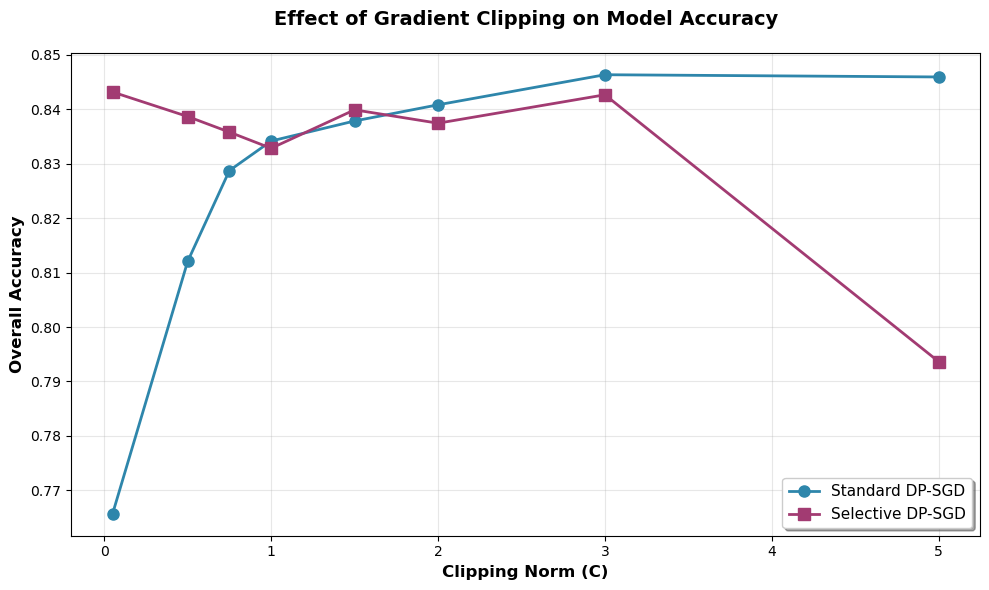

Plot saved to plots/clipping_accuracy.png


In [72]:
# Overall accuracy comparison
plot_clipping_accuracy(clipping_results, save_path='plots/clipping_accuracy.png')

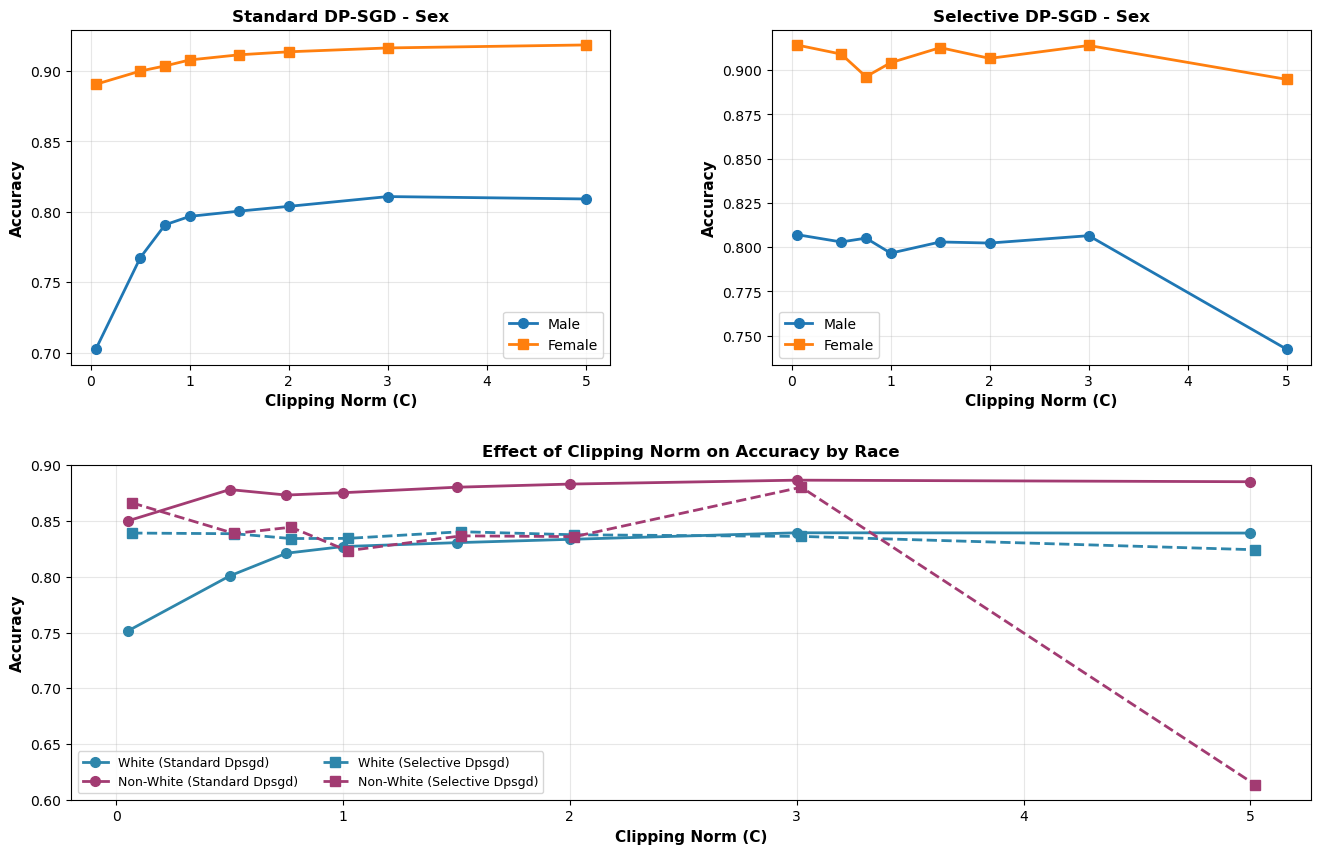

✓ Plot saved to plots/clipping_accuracy_groups.png


In [73]:
# Accuracy broken down by demographic groups
plot_clipping_accuracy_by_groups(clipping_results, save_path='plots/clipping_accuracy_groups.png')

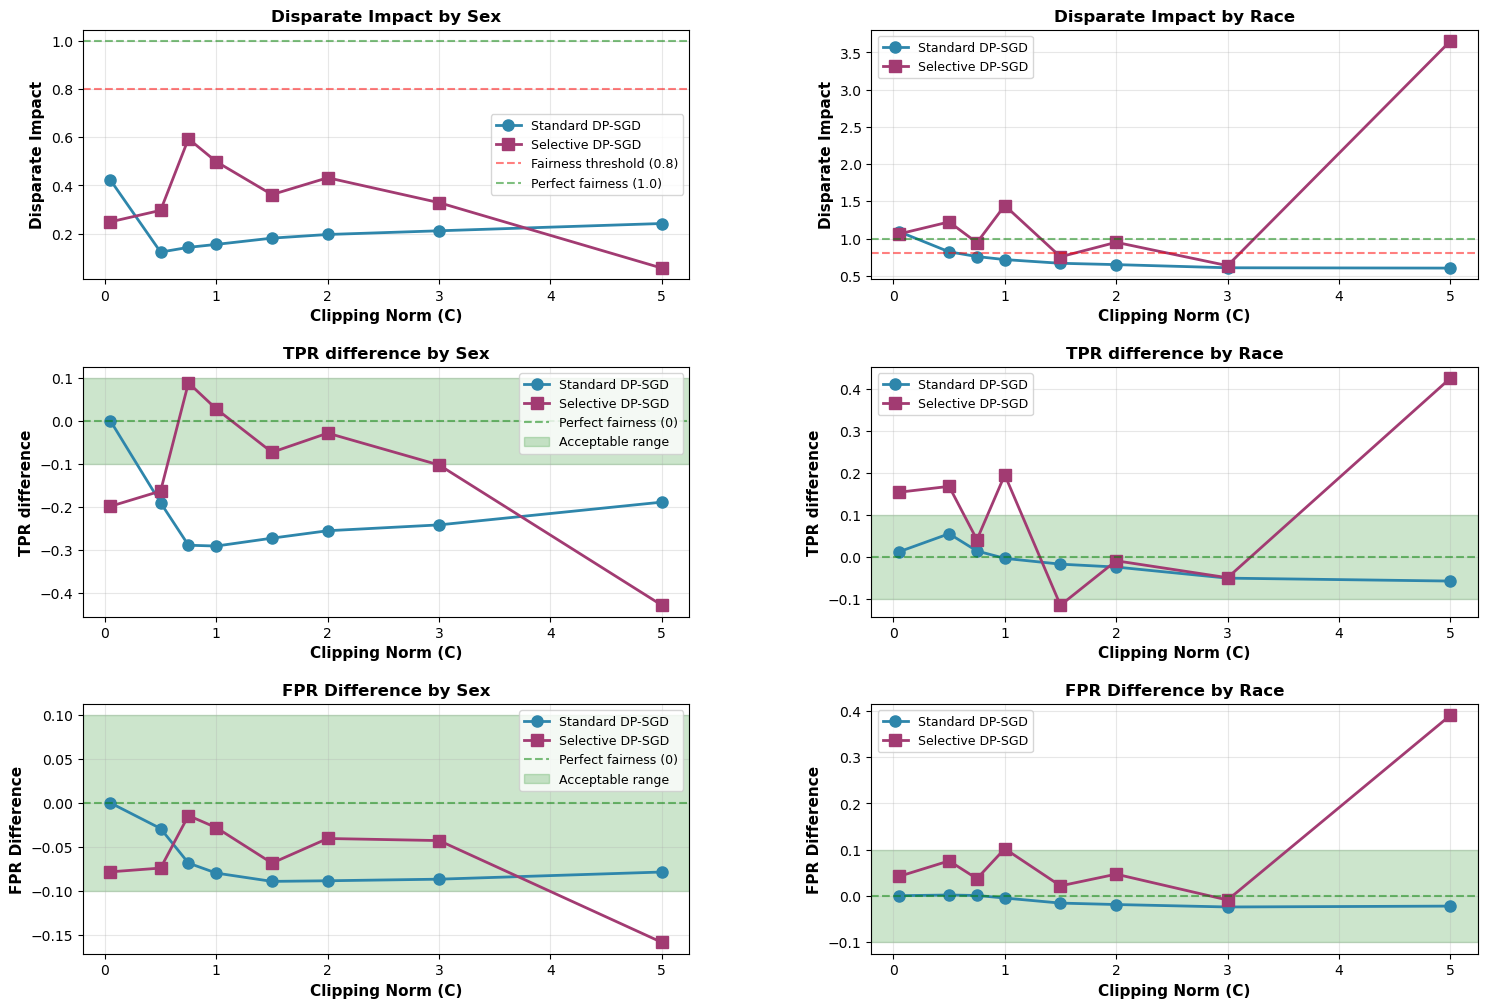

Plot saved to plots/clipping_fairness.png


In [74]:
# Fairness metrics (DI, EO, Equalized Odds)
plot_clipping_fairness(clipping_results, save_path='plots/clipping_fairness.png')

## Noise Plots

In [75]:
def plot_noise_accuracy(results_dict, save_path='noise_accuracy.png'):
    """Plot overall accuracy vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    standard_acc = [results_dict[n]['standard_dpsgd']['accuracy'] for n in noise_multipliers]
    selective_acc = [results_dict[n]['selective_dpsgd']['accuracy'] for n in noise_multipliers]
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_multipliers, standard_acc, marker='o', linewidth=2, 
             markersize=8, label='Standard DP-SGD', color='#2E86AB')
    plt.plot(noise_multipliers, selective_acc, marker='s', linewidth=2, 
             markersize=8, label='Selective DP-SGD', color='#A23B72')
    
    plt.xlabel('Noise Multiplier (σ)', fontsize=12, fontweight='bold')
    plt.ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    plt.title('Effect of Noise on Model Accuracy', 
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=11, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_accuracy_by_groups(results_dict, save_path='noise_accuracy_groups.png'):
    """Plot accuracy by demographic groups vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # --- SEX GROUPS ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for model_type, ax, title in [('standard_dpsgd', ax1, 'Standard DP-SGD - Sex'),
                                    ('selective_dpsgd', ax2, 'Selective DP-SGD - Sex')]:
        male_acc = []
        female_acc = []
        
        for n in noise_multipliers:
            # sex_metrics is a tuple: (DataFrame, disparities_dict)
            sex_data = results_dict[n][model_type]['sex_metrics']
            if isinstance(sex_data, tuple):
                sex_metrics, _ = sex_data
            else:
                sex_metrics = sex_data  # Fallback if it's just the DataFrame
            
            male_acc.append(sex_metrics[sex_metrics['group'] == 'Male']['accuracy'].values[0])
            female_acc.append(sex_metrics[sex_metrics['group'] == 'Female']['accuracy'].values[0])
        
        ax.plot(noise_multipliers, male_acc, marker='o', linewidth=2, 
                markersize=7, label='Male', color='#1F77B4')
        ax.plot(noise_multipliers, female_acc, marker='s', linewidth=2, 
                markersize=7, label='Female', color='#FF7F0E')
        
        ax.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # --- RACE GROUPS ---
    ax3 = fig.add_subplot(gs[1, :])
    
    colors = ['#2E86AB', '#A23B72']
    race_groups = ['White', 'Non-White']
    
    for i, model_type in enumerate(['standard_dpsgd', 'selective_dpsgd']):
        race_accs = {group: [] for group in race_groups}
        
        for n in noise_multipliers:
            # race_metrics is a tuple: (DataFrame, disparities_dict)
            race_data = results_dict[n][model_type]['race_metrics']
            if isinstance(race_data, tuple):
                race_metrics, _ = race_data
            else:
                race_metrics = race_data  # Fallback if it's just the DataFrame
            
            for group in race_groups:
                acc_val = race_metrics[race_metrics['group'] == group]['accuracy'].values[0]
                race_accs[group].append(acc_val)
        
        offset = i * 0.02
        for j, group in enumerate(race_groups):
            marker = 'o' if model_type == 'standard_dpsgd' else 's'
            linestyle = '-' if model_type == 'standard_dpsgd' else '--'
            label = f"{group} ({model_type.replace('_', ' ').title()})"
            
            ax3.plot([n + offset for n in noise_multipliers], race_accs[group], 
                    marker=marker, linewidth=2, markersize=7, 
                    label=label, linestyle=linestyle, color=colors[j])
    
    ax3.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of Noise on Accuracy by Race', 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_fairness(results_dict, save_path='noise_fairness.png'):
    """Plot fairness metrics vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    fairness_metrics = [
        ('disparate_impact', 'Disparate Impact', 0.8, 1.0),
        ('equal_opportunity_difference', 'Equal Opportunity Difference', -0.1, 0.1),
        ('equalized_odds_tpr_diff', 'Equalized Odds (TPR Diff)', -0.1, 0.1),
    ]
    
    for idx, (metric_key, metric_name, lower_bound, upper_bound) in enumerate(fairness_metrics):
        # Sex
        ax1 = fig.add_subplot(gs[idx, 0])
        
        standard_sex = [results_dict[n]['standard_dpsgd']['sex_disparities'][metric_key] 
                        for n in noise_multipliers]
        selective_sex = [results_dict[n]['selective_dpsgd']['sex_disparities'][metric_key] 
                         for n in noise_multipliers]
        
        ax1.plot(noise_multipliers, standard_sex, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax1.plot(noise_multipliers, selective_sex, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, 
                       label='Fairness threshold (0.8)')
            ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (1.0)')
        else:
            ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (0)')
            ax1.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                       label=f'Acceptable range')
        
        ax1.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax1.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax1.set_title(f'{metric_name} by Sex', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Race
        ax2 = fig.add_subplot(gs[idx, 1])
        
        standard_race = [results_dict[n]['standard_dpsgd']['race_disparities'][metric_key] 
                         for n in noise_multipliers]
        selective_race = [results_dict[n]['selective_dpsgd']['race_disparities'][metric_key] 
                          for n in noise_multipliers]
        
        ax2.plot(noise_multipliers, standard_race, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax2.plot(noise_multipliers, selective_race, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
            ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
        else:
            ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
            ax2.axhspan(lower_bound, upper_bound, alpha=0.2, color='green')
        
        ax2.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax2.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax2.set_title(f'{metric_name} by Race', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9, loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_accuracy_by_groups(results_dict, save_path='noise_accuracy_groups.png'):
    """Plot accuracy by demographic groups vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # --- SEX GROUPS ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for model_type, ax, title in [('standard_dpsgd', ax1, 'Standard DP-SGD - Sex'),
                                    ('selective_dpsgd', ax2, 'Selective DP-SGD - Sex')]:
        male_acc = []
        female_acc = []
        
        for n in noise_multipliers:
            # sex_metrics is a tuple: (DataFrame, disparities_dict)
            sex_data = results_dict[n][model_type]['sex_metrics']
            if isinstance(sex_data, tuple):
                sex_metrics, _ = sex_data
            else:
                sex_metrics = sex_data  # Fallback if it's just the DataFrame
            
            male_acc.append(sex_metrics[sex_metrics['group'] == 'Male']['accuracy'].values[0])
            female_acc.append(sex_metrics[sex_metrics['group'] == 'Female']['accuracy'].values[0])
        
        ax.plot(noise_multipliers, male_acc, marker='o', linewidth=2, 
                markersize=7, label='Male', color='#1F77B4')
        ax.plot(noise_multipliers, female_acc, marker='s', linewidth=2, 
                markersize=7, label='Female', color='#FF7F0E')
        
        ax.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # --- RACE GROUPS ---
    ax3 = fig.add_subplot(gs[1, :])
    
    colors = ['#2E86AB', '#A23B72']
    race_groups = ['White', 'Non-White']
    
    for i, model_type in enumerate(['standard_dpsgd', 'selective_dpsgd']):
        race_accs = {group: [] for group in race_groups}
        
        for n in noise_multipliers:
            # race_metrics is a tuple: (DataFrame, disparities_dict)
            race_data = results_dict[n][model_type]['race_metrics']
            if isinstance(race_data, tuple):
                race_metrics, _ = race_data
            else:
                race_metrics = race_data  # Fallback if it's just the DataFrame
            
            for group in race_groups:
                acc_val = race_metrics[race_metrics['group'] == group]['accuracy'].values[0]
                race_accs[group].append(acc_val)
        
        offset = i * 0.02
        for j, group in enumerate(race_groups):
            marker = 'o' if model_type == 'standard_dpsgd' else 's'
            linestyle = '-' if model_type == 'standard_dpsgd' else '--'
            label = f"{group} ({model_type.replace('_', ' ').title()})"
            
            ax3.plot([n + offset for n in noise_multipliers], race_accs[group], 
                    marker=marker, linewidth=2, markersize=7, 
                    label=label, linestyle=linestyle, color=colors[j])
    
    ax3.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of Noise on Accuracy by Race', 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_fairness(results_dict, save_path='noise_fairness.png'):
    """Plot fairness metrics vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    fairness_metrics = [
        ('disparate_impact', 'Disparate Impact', 0.8, 1.0),
        ('equal_opportunity_difference', 'TPR Difference', -0.1, 0.1),
        ('equalized_odds_fpr_diff', 'FPR Difference', -0.1, 0.1),
    ]
    
    for idx, (metric_key, metric_name, lower_bound, upper_bound) in enumerate(fairness_metrics):
        # Sex
        ax1 = fig.add_subplot(gs[idx, 0])
        
        standard_sex = [results_dict[n]['standard_dpsgd']['sex_disparities'][metric_key] 
                        for n in noise_multipliers]
        selective_sex = [results_dict[n]['selective_dpsgd']['sex_disparities'][metric_key] 
                         for n in noise_multipliers]
        
        ax1.plot(noise_multipliers, standard_sex, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax1.plot(noise_multipliers, selective_sex, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, 
                       label='Fairness threshold (0.8)')
            ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (1.0)')
        else:
            ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (0)')
            ax1.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                       label=f'Acceptable range')
        
        ax1.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax1.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax1.set_title(f'{metric_name} by Sex', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Race
        ax2 = fig.add_subplot(gs[idx, 1])
        
        standard_race = [results_dict[n]['standard_dpsgd']['race_disparities'][metric_key] 
                         for n in noise_multipliers]
        selective_race = [results_dict[n]['selective_dpsgd']['race_disparities'][metric_key] 
                          for n in noise_multipliers]
        
        ax2.plot(noise_multipliers, standard_race, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax2.plot(noise_multipliers, selective_race, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
            ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
        else:
            ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
            ax2.axhspan(lower_bound, upper_bound, alpha=0.2, color='green')
        
        ax2.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax2.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax2.set_title(f'{metric_name} by Race', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9, loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"Plot saved to {save_path}")

In [76]:
# Sweep through different noise multiplier values
noise_results = run_parameter_sweep(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test=y_test,
    X_test_df=X_test,
    sensitive_indices=sensitive_indices,
    param_type='noise',
    param_values=[0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0],
    fixed_clipping=1.0,
    lr=0.01,
    epochs=10,
    batch_size=64
)


RUNNING NOISE PARAMETER SWEEP
Testing 7 values: [0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0]
This will train 14 models (Standard + Selective)



Sweeping noise:   0%|          | 0/7 [00:00<?, ?it/s]


--- Testing: noise=0.5 ---
Training Standard DP-SGD...

TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 0.5
  - Max grad norm: 1.0
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5478
Epoch 2/10 - Loss: 0.5071
Epoch 3/10 - Loss: 0.4468
Epoch 4/10 - Loss: 0.4041
Epoch 5/10 - Loss: 0.3857
Epoch 6/10 - Loss: 0.3861
Epoch 7/10 - Loss: 0.3847
Epoch 8/10 - Loss: 0.3866
Epoch 9/10 - Loss: 0.3806
Epoch 10/10 - Loss: 0.3764
Training completed

PRIVACY BUDGET
Epsilon (ε): 6.3810
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=6.3810 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=6.381)
Overall Accuracy: 0.8330
AUC-ROC Score: 0.8852

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.229321 0.540842 0.093147  0.795525
Female       0.036789 0.247956 0.010267  0.906963

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1604
Equal Opportunity Difference (TPR diff): -0.2929
Equalized Odds Differences: TPR diff=-0.2929, FPR diff=-0.0829

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  14%|█▍        | 1/7 [00:31<03:09, 31.56s/it]

Epoch 10/10 - Loss: 0.0054
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 7.6945
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=7.6945 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=7.694)
Overall Accuracy: 0.8429
AUC-ROC Score: 0.8954

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.225154 0.552004 0.082280  0.806481
Female       0.063241 0.400545 0.020876  0.914564

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2809
Equal Opportunity Difference (TPR diff): -0.1515
Equalized Odds Differences: TPR diff=-0.1515, FPR diff=-0.0614

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.172137 0.520057 0.053781  0.838045
Non-White       0.161858 0.607306 0.080699  0.87

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5439
Epoch 2/10 - Loss: 0.4789
Epoch 3/10 - Loss: 0.4356
Epoch 4/10 - Loss: 0.4059
Epoch 5/10 - Loss: 0.3895
Epoch 6/10 - Loss: 0.3842
Epoch 7/10 - Loss: 0.3800
Epoch 8/10 - Loss: 0.3740
Epoch 9/10 - Loss: 0.3738
Epoch 10/10 - Loss: 0.3755
Training completed

PRIVACY BUDGET
Epsilon (ε): 1.3108
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=1.3108 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=1.311)
Overall Accuracy: 0.8334
AUC-ROC Score: 0.8854

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.228858 0.540335 0.092703  0.795679
Female       0.038005 0.256131 0.010609  0.907571

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1661
Equal Opportunity Difference (TPR diff): -0.2842
Equalized Odds Differences: TPR diff=-0.2842, FPR diff=-0.0821

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  29%|██▊       | 2/7 [01:01<02:34, 30.81s/it]

Epoch 10/10 - Loss: 0.0052
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 1.9514
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=1.9514 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=1.951)
Overall Accuracy: 0.8389
AUC-ROC Score: 0.8922

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.237500 0.566717 0.093591  0.803086
Female       0.058072 0.354223 0.020876  0.909395

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2445
Equal Opportunity Difference (TPR diff): -0.2125
Equalized Odds Differences: TPR diff=-0.2125, FPR diff=-0.0727

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.167825 0.511562 0.050891  0.838045
Non-White       0.231527 0.744292 0.138103  0.84

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5353
Epoch 2/10 - Loss: 0.4824
Epoch 3/10 - Loss: 0.4406
Epoch 4/10 - Loss: 0.4142
Epoch 5/10 - Loss: 0.3960
Epoch 6/10 - Loss: 0.3894
Epoch 7/10 - Loss: 0.3843
Epoch 8/10 - Loss: 0.3815
Epoch 9/10 - Loss: 0.3845
Epoch 10/10 - Loss: 0.3837
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8323
AUC-ROC Score: 0.8842

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.226080 0.533739 0.091595  0.794444
Female       0.036181 0.245232 0.009925  0.906963

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1600
Equal Opportunity Difference (TPR diff): -0.2885
Equalized Odds Differences: TPR diff=-0.2885, FPR diff=-0.0817

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  43%|████▎     | 3/7 [01:32<02:02, 30.74s/it]

Epoch 10/10 - Loss: 0.0057
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8438
AUC-ROC Score: 0.8982

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.262346 0.613394 0.108893  0.806636
Female       0.046823 0.337875 0.010267  0.916996

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1785
Equal Opportunity Difference (TPR diff): -0.2755
Equalized Odds Differences: TPR diff=-0.2755, FPR diff=-0.0986

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.207595 0.588485 0.078022  0.837326
Non-White       0.085151 0.392694 0.029118  0.88

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4998
Epoch 2/10 - Loss: 0.4719
Epoch 3/10 - Loss: 0.4287
Epoch 4/10 - Loss: 0.3944
Epoch 5/10 - Loss: 0.3825
Epoch 6/10 - Loss: 0.3813
Epoch 7/10 - Loss: 0.3769
Epoch 8/10 - Loss: 0.3816
Epoch 9/10 - Loss: 0.3831
Epoch 10/10 - Loss: 0.3824
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.3414
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.3414 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.341)
Overall Accuracy: 0.8326
AUC-ROC Score: 0.8863

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.231481 0.543886 0.094921  0.795216
Female       0.037397 0.247956 0.010951  0.906355

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1616
Equal Opportunity Difference (TPR diff): -0.2959
Equalized Odds Differences: TPR diff=-0.2959, FPR diff=-0.0840

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  57%|█████▋    | 4/7 [02:02<01:31, 30.40s/it]

Epoch 10/10 - Loss: 0.0058
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.4012
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.4012 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.401)
Overall Accuracy: 0.8417
AUC-ROC Score: 0.8903

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.248302 0.584982 0.101131  0.803395
Female       0.079355 0.485014 0.028405  0.917300

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.3196
Equal Opportunity Difference (TPR diff): -0.1000
Equalized Odds Differences: TPR diff=-0.1000, FPR diff=-0.0727

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.204241 0.585654 0.074490  0.839243
Non-White       0.116115 0.410959 0.062396  0.85

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5436
Epoch 2/10 - Loss: 0.4945
Epoch 3/10 - Loss: 0.4501
Epoch 4/10 - Loss: 0.4178
Epoch 5/10 - Loss: 0.3968
Epoch 6/10 - Loss: 0.3961
Epoch 7/10 - Loss: 0.3821
Epoch 8/10 - Loss: 0.3834
Epoch 9/10 - Loss: 0.3872
Epoch 10/10 - Loss: 0.3836
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.2374
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.2374 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.237)
Overall Accuracy: 0.8308
AUC-ROC Score: 0.8836

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.224537 0.529173 0.091373  0.793210
Female       0.033445 0.223433 0.009582  0.904834

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1490
Equal Opportunity Difference (TPR diff): -0.3057
Equalized Odds Differences: TPR diff=-0.3057, FPR diff=-0.0818

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  71%|███████▏  | 5/7 [02:31<01:00, 30.08s/it]

Epoch 10/10 - Loss: 0.0061
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.2543
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.2543 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.254)
Overall Accuracy: 0.8408
AUC-ROC Score: 0.8751

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.232870 0.558092 0.090707  0.802469
Female       0.086957 0.514986 0.033196  0.916388

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.3734
Equal Opportunity Difference (TPR diff): -0.0431
Equalized Odds Differences: TPR diff=-0.0431, FPR diff=-0.0575

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.200407 0.575743 0.072724  0.838045
Non-White       0.085855 0.315068 0.044093  0.85

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5324
Epoch 2/10 - Loss: 0.4768
Epoch 3/10 - Loss: 0.4421
Epoch 4/10 - Loss: 0.4081
Epoch 5/10 - Loss: 0.3924
Epoch 6/10 - Loss: 0.3831
Epoch 7/10 - Loss: 0.3865
Epoch 8/10 - Loss: 0.3850
Epoch 9/10 - Loss: 0.3818
Epoch 10/10 - Loss: 0.3799
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.1498
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.1498 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.150)
Overall Accuracy: 0.8332
AUC-ROC Score: 0.8837

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.225309 0.535261 0.089820  0.796142
Female       0.032533 0.226158 0.008214  0.906355

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1444
Equal Opportunity Difference (TPR diff): -0.3091
Equalized Odds Differences: TPR diff=-0.3091, FPR diff=-0.0816

=== Fairness by race_grouped ===
    group  positive_rate

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch 1/10 - Loss: 0.0079
Epoch 2/10 - Loss: 0.0074
Epoch 3/10 - Loss: 0.0073
Epoch 4/10 - Loss: 0.0074
Epoch 5/10 - Loss: 0.0081
Epoch 6/10 - Loss: 0.0083
Epoch 7/10 - Loss: 0.0083
Epoch 8/10 - Loss: 0.0089
Epoch 9/10 - Loss: 0.0074


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
Sweeping noise:  86%|████████▌ | 6/7 [03:02<00:30, 30.15s/it]

Epoch 10/10 - Loss: 0.0088
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.1643
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.1643 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.164)
Overall Accuracy: 0.8212
AUC-ROC Score: 0.8449

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.181481 0.451040 0.063650  0.788735
Female       0.155366 0.681199 0.089322  0.885071

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.8561
Equal Opportunity Difference (TPR diff): 0.2302
Equalized Odds Differences: TPR diff=0.2302, FPR diff=0.0257

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.183637 0.507787 0.073367  0.820316
Non-White       0.108374 0.287671 0.075707  0.82617

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5211
Epoch 2/10 - Loss: 0.4739
Epoch 3/10 - Loss: 0.4379
Epoch 4/10 - Loss: 0.4044
Epoch 5/10 - Loss: 0.3915
Epoch 6/10 - Loss: 0.3853
Epoch 7/10 - Loss: 0.3834
Epoch 8/10 - Loss: 0.3818
Epoch 9/10 - Loss: 0.3843
Epoch 10/10 - Loss: 0.3869
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.0881
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.0881 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.088)
Overall Accuracy: 0.8313
AUC-ROC Score: 0.8846

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.221451 0.524099 0.089155  0.793210
Female       0.031925 0.223433 0.007871  0.906355

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1442
Equal Opportunity Difference (TPR diff): -0.3007
Equalized Odds Differences: TPR diff=-0.3007, FPR diff=-0.0813

=== Fairness by race_grouped ===
    group  positive_rate

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch 1/10 - Loss: 0.0075
Epoch 2/10 - Loss: 0.0084
Epoch 3/10 - Loss: 0.0072
Epoch 4/10 - Loss: 0.0071
Epoch 5/10 - Loss: 0.0075
Epoch 6/10 - Loss: 0.0060
Epoch 7/10 - Loss: 0.0072
Epoch 8/10 - Loss: 0.0061
Epoch 9/10 - Loss: 0.0059


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
Sweeping noise: 100%|██████████| 7/7 [03:32<00:00, 30.29s/it]

Epoch 10/10 - Loss: 0.0064
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.1240
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [57, 58, 59, 60, 61, 62, 63]) have ε=0.1240 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.124)
Overall Accuracy: 0.8220
AUC-ROC Score: 0.8827

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.159877 0.406393 0.052118  0.783179
Female       0.024019 0.152589 0.007871  0.898449

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1502
Equal Opportunity Difference (TPR diff): -0.2538
Equalized Odds Differences: TPR diff=-0.2538, FPR diff=-0.0442

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.106612 0.353469 0.022636  0.818999
Non-White       0.158339 0.493151 0.097338  0.83

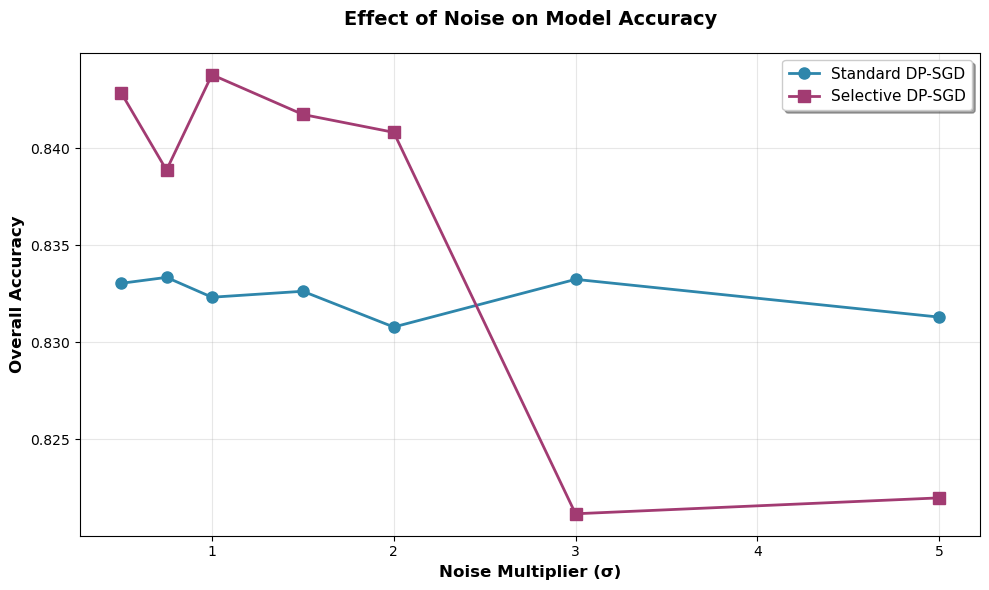

Plot saved to plots/noise_accuracy.png


In [77]:
# Overall accuracy + privacy-utility tradeoff
plot_noise_accuracy(noise_results, save_path='plots/noise_accuracy.png')

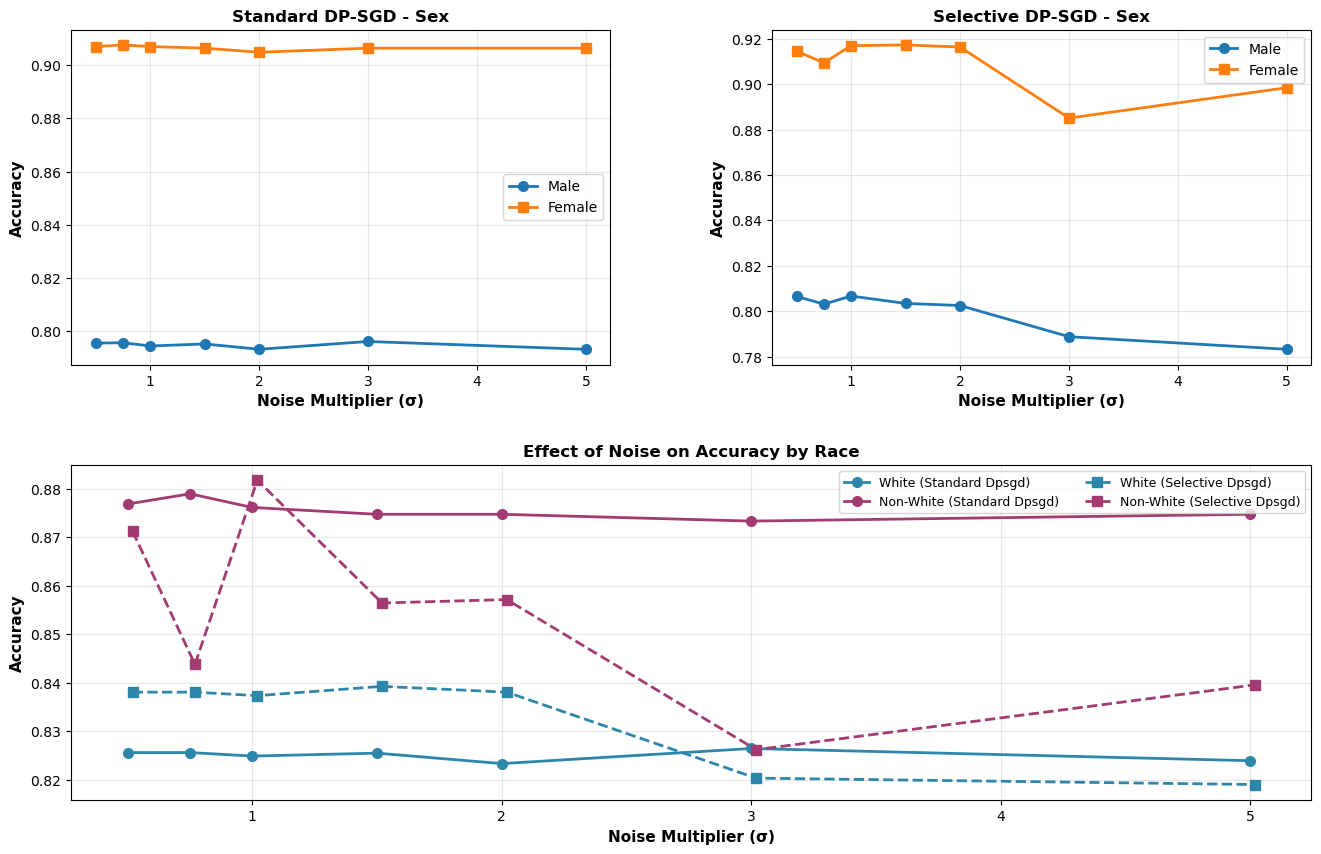

Plot saved to plots/noise_accuracy_groups.png


In [78]:
# Accuracy broken down by demographic groups
plot_noise_accuracy_by_groups(noise_results, save_path='plots/noise_accuracy_groups.png')

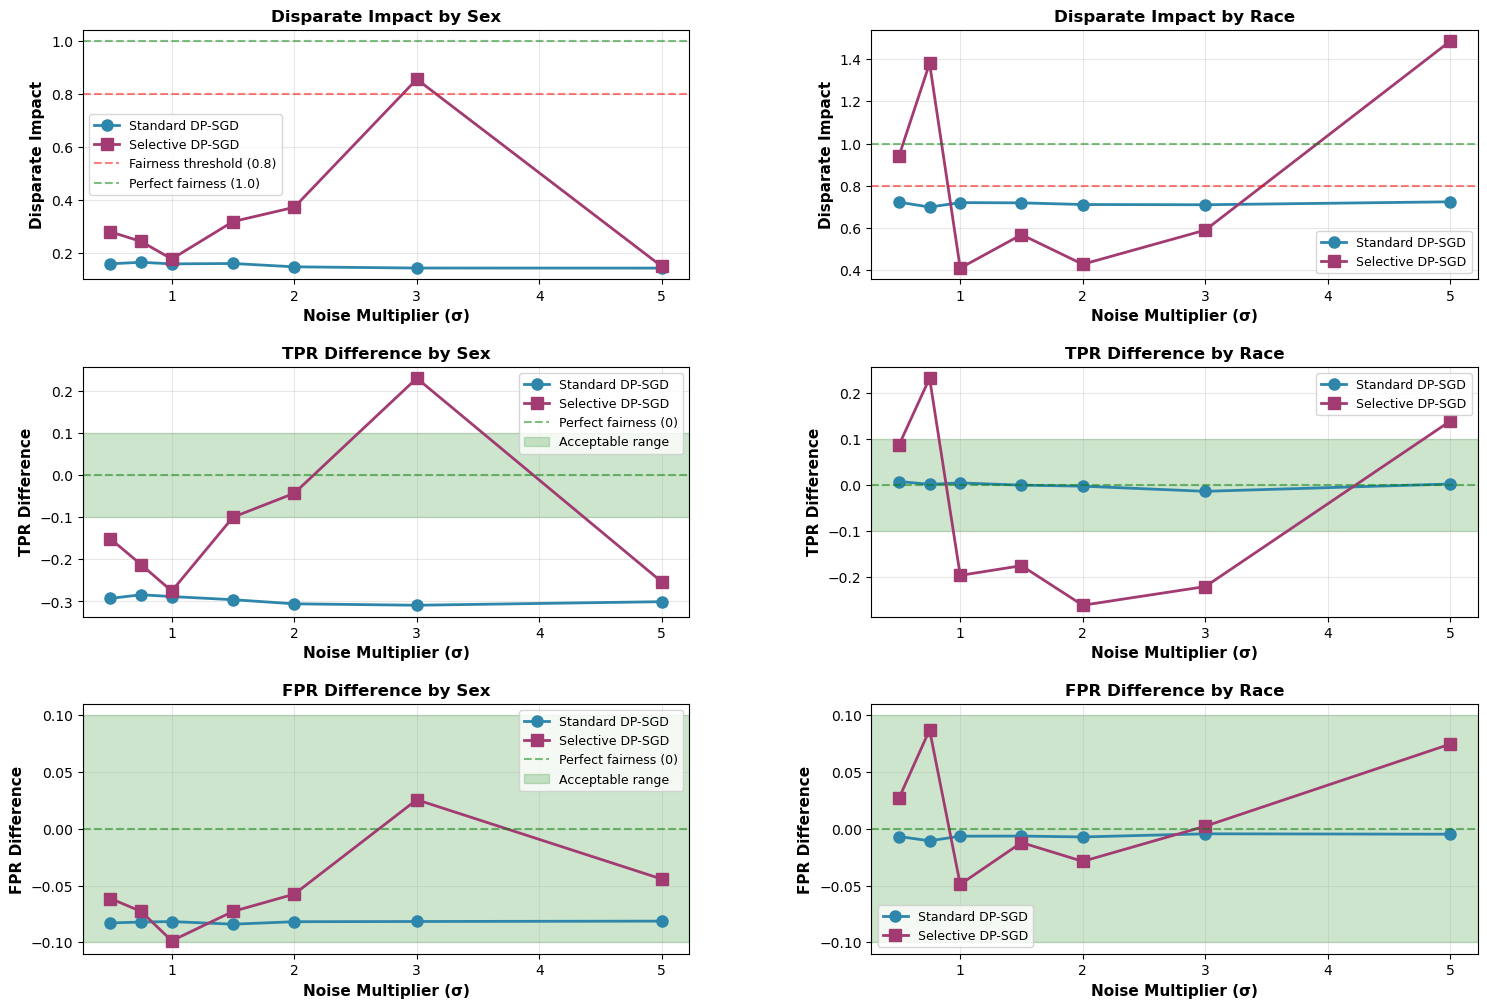

Plot saved to plots/noise_fairness.png


In [79]:
# Fairness metrics across noise levels
plot_noise_fairness(noise_results, save_path='plots/noise_fairness.png')